# Algorithmic Trading Model for Cramer COVID-19 Index Using Python Take 3
### David Lowe
### June 8, 2020

SUMMARY: The purpose of this project is to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: CNBC’s Jim Cramer, the host of Mad Money show, presented a list of stocks on April 27 that he believes will work well in this coronavirus-plagued market. The ‘Cramer COVID-19 Index’ contains 100 companies that touch 17 sectors where investors can expect a positive return in this volatile market environment. The project aims to analyze these 100 stocks and develop strategies for trading these stocks, either individually or in groups.

In iteration Take1, we constructed the necessary code segments for downloading and visualizing the index and the stocks. The script leveraged various data sources, both free and paid subscriptions, for pulling the required dataset together.

In iteration Take2, we built on the previous analysis by constructing a dual moving average crossover trading model (20-day and 50-day) and applying the model to the 100 stocks in the index. For each stock, we also identified the entry and exit dates starting January 1, 2019.

In this Take3 iteration, we will build on the previous analysis by constructing a module to calculate profit and loss for the dual moving average crossover trading model and applying the model to the 100 stocks in the index. For each stock, we will identify the entry and exit dates starting around January 1, 2019.

NOTE: This script calculates the index value by using the number of outstanding shares from each company. Such an approach may not match how CNBC calculates this index (https://www.cnbc.com/cramer-covid-19-stocks/). This script is for educational purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

ANALYSIS: Refer to the list of profit and loss amounts for each stock in the index under Task 4.

CONCLUSION: Refer to the list of profit and loss amounts for each stock in the index under Task 4.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: IEX Cloud and Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Develop Strategy and Train Model
4. Back-test Model
5. Evaluate Performance

## Task 1. Prepare Environment

In [7]:
import os
import sys
import smtplib
import numpy as np
import pandas as pd
import requests
import json
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import sleep
from dotenv import load_dotenv

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useDocker = True
if not useDocker:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 120)
pd.set_option("display.width", 140)

In [9]:
# Define the function for sending the status notification emails
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if (sender is None) or (receiver is None) or (gateway is None) or (smtpuser is None) or (password is None):
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Algorithmic Trading Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [10]:
if notifyStatus: email_notify("Task 1. Prepare Environment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [11]:
# Check and see whether the API key is available
alphavantage_key = os.environ.get('ALPHAVANTAGE_API')
if alphavantage_key is None: sys.exit("API key for Alpha Vantage not available. Script Processing Aborted!!!")

# Check and see whether the API key is available
iexcloud_key = os.environ.get('IEXCLOUD_API')
if iexcloud_key is None: sys.exit("API key for IEX Cloud not available. Script Processing Aborted!!!")

# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [12]:
# Specify the parameters for the trading strategy
fast_ma = 20
slow_ma = 50

model_start_date = datetime(2019, 1, 1)
print("Starting date for the model:", model_start_date)
stock_start_date = model_start_date - timedelta(days=int(slow_ma*1.5)) # Need more pricing data to calculate moving averages

# model_end_date = datetime(2020, 1, 1)
model_end_date = datetime.now()
print("Ending date for the model:", model_end_date)

stock_data_dates = pd.date_range(start=stock_start_date, end=model_end_date)

Starting date for the model: 2019-01-01 00:00:00
Ending date for the model: 2020-05-28 23:40:28.733722


In [13]:
if notifyStatus: email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2. Acquire and Pre-Process Data

In [14]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [15]:
dataset_path = 'https://www.dainesanalytics.com/datasets/cramer-covid19-index/Cramer_COVID-19_Index.csv'
stock_meta = pd.read_csv(dataset_path, sep=',')
stock_meta.set_index('Symbol', inplace=True)
stock_meta = stock_meta.sort_index(ascending = True)
stock_meta.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, AAPL to ZTS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    100 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


In [16]:
# Take a peek at the dataframe after import
stock_meta.head()

Name
Symbol                     
AAPL                  Apple
ABBV                 AbbVie
ABT             Abbott Labs
ADBE                  Adobe
AKAM    Akamai Technologies

In [17]:
stock_list = stock_meta.index.tolist()
if verbose: print('Stocks to process:', stock_list)

In [18]:
for ticker in stock_list:
    iexcloud_url = "https://cloud.iexapis.com/stable/stock/%s/stats/sharesOutstanding?token=%s" % (ticker, iexcloud_key)
    sleep(1)
    response = requests.get(iexcloud_url)
    share_data = json.loads(response.text)
    stock_meta.loc[ticker,'Share_Outstanding'] = share_data
    print('Company outstanding share number retrieved for', ticker, ':', share_data)

Company outstanding share number retrieved for AAPL : 4334340000
Company outstanding share number retrieved for ABBV : 1762340000
Company outstanding share number retrieved for ABT : 1768850000
Company outstanding share number retrieved for ADBE : 481801000
Company outstanding share number retrieved for AKAM : 162274000
Company outstanding share number retrieved for AMD : 1171190000
Company outstanding share number retrieved for AMT : 443306000
Company outstanding share number retrieved for AMZN : 498776000
Company outstanding share number retrieved for ATVI : 770486000
Company outstanding share number retrieved for BAX : 508836000
Company outstanding share number retrieved for BNTX : 228604644
Company outstanding share number retrieved for BSX : 1399350000
Company outstanding share number retrieved for BYND : 62236700
Company outstanding share number retrieved for CAG : 487076000
Company outstanding share number retrieved for CCI : 416751000
Company outstanding share number retrieved 

In [19]:
stock_meta.head()

Name  Share_Outstanding
Symbol                                        
AAPL                  Apple       4.334340e+09
ABBV                 AbbVie       1.762340e+09
ABT             Abbott Labs       1.768850e+09
ADBE                  Adobe       4.818010e+08
AKAM    Akamai Technologies       1.622740e+08

In [20]:
stock_meta.tail()

Name  Share_Outstanding
Symbol                               
WMT        Walmart       2.833700e+09
WORK         Slack       4.254840e+08
ZM      Zoom Video       1.675570e+08
ZS         Zscaler       1.293520e+08
ZTS         Zoetis       4.749410e+08

In [21]:
total_shares = stock_meta['Share_Outstanding'].sum()
print('Total number of outstanding shares used to calculate the index:', total_shares)

Total number of outstanding shares used to calculate the index: 72940926350.0


In [22]:
# Create the dataframe to hold the index and individual stock components
columns = ['JC_MAD']
index_df = pd.DataFrame(index=stock_data_dates, columns=columns)
index_df = index_df.fillna(0.0)
index_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 589 entries, 2018-10-18 to 2020-05-28
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   JC_MAD  589 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


In [23]:
index_df.head()

JC_MAD
2018-10-18     0.0
2018-10-19     0.0
2018-10-20     0.0
2018-10-21     0.0
2018-10-22     0.0

In [24]:
# Create the dataframe to hold the stock opening prices
stock_open_df = pd.DataFrame(index=stock_data_dates)
stock_open_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 589 entries, 2018-10-18 to 2020-05-28
Freq: D
Empty DataFrame

In [25]:
# Create the dataframe to hold the stock closing prices
stock_close_df = pd.DataFrame(index=stock_data_dates)
stock_close_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 589 entries, 2018-10-18 to 2020-05-28
Freq: D
Empty DataFrame

In [26]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

for ticker in stock_list:
    quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, ticker, quandl_key)
    response = requests.get(quandl_url)
    sleep(1)
    quandl_dict = json.loads(response.text)
    stock_data = pd.DataFrame(quandl_dict['datatable']['data'])
    print(len(stock_data), 'data points retrieved from the API call for:', ticker)
    stock_data.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
    stock_data.index = pd.to_datetime(stock_data.date)
    stock_data = stock_data.sort_index(ascending = True)
    stock_open = stock_data.loc[:, ['open']]
    stock_open.rename(columns={'open': ticker}, inplace=True)
    stock_open_df = pd.concat([stock_open_df, stock_open], axis=1)
    stock_close = stock_data.loc[:, ['closeunadj']]
    stock_close.rename(columns={'closeunadj': ticker}, inplace=True)
    stock_close_df = pd.concat([stock_close_df, stock_close], axis=1)
    component_close = stock_data.loc[:, ['closeunadj']] * stock_meta.loc[ticker, 'Share_Outstanding'] / total_shares
    component_close.rename(columns={'closeunadj': ticker}, inplace=True)
    index_df = pd.concat([index_df, component_close], axis=1)

404 data points retrieved from the API call for: AAPL
404 data points retrieved from the API call for: ABBV
404 data points retrieved from the API call for: ABT
404 data points retrieved from the API call for: ADBE
404 data points retrieved from the API call for: AKAM
404 data points retrieved from the API call for: AMD
404 data points retrieved from the API call for: AMT
404 data points retrieved from the API call for: AMZN
404 data points retrieved from the API call for: ATVI
404 data points retrieved from the API call for: BAX
159 data points retrieved from the API call for: BNTX
404 data points retrieved from the API call for: BSX
271 data points retrieved from the API call for: BYND
404 data points retrieved from the API call for: CAG
404 data points retrieved from the API call for: CCI
404 data points retrieved from the API call for: CHGG
241 data points retrieved from the API call for: CHWY
404 data points retrieved from the API call for: CL
404 data points retrieved from the AP

In [27]:
stock_open_df.dropna(inplace=True)
stock_open_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2019-10-10 to 2020-05-28
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    159 non-null    float64
 1   ABBV    159 non-null    float64
 2   ABT     159 non-null    float64
 3   ADBE    159 non-null    float64
 4   AKAM    159 non-null    float64
 5   AMD     159 non-null    float64
 6   AMT     159 non-null    float64
 7   AMZN    159 non-null    float64
 8   ATVI    159 non-null    float64
 9   BAX     159 non-null    float64
 10  BNTX    159 non-null    float64
 11  BSX     159 non-null    float64
 12  BYND    159 non-null    float64
 13  CAG     159 non-null    float64
 14  CCI     159 non-null    float64
 15  CHGG    159 non-null    float64
 16  CHWY    159 non-null    float64
 17  CL      159 non-null    float64
 18  CLX     159 non-null    float64
 19  CMG     159 non-null    float64
 20  CNC     159 non-null    float64
 21  COR     159 non-nul

In [28]:
stock_close_df.dropna(inplace=True)
stock_close_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2019-10-10 to 2020-05-28
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    159 non-null    float64
 1   ABBV    159 non-null    float64
 2   ABT     159 non-null    float64
 3   ADBE    159 non-null    float64
 4   AKAM    159 non-null    float64
 5   AMD     159 non-null    float64
 6   AMT     159 non-null    float64
 7   AMZN    159 non-null    float64
 8   ATVI    159 non-null    float64
 9   BAX     159 non-null    float64
 10  BNTX    159 non-null    float64
 11  BSX     159 non-null    float64
 12  BYND    159 non-null    float64
 13  CAG     159 non-null    float64
 14  CCI     159 non-null    float64
 15  CHGG    159 non-null    float64
 16  CHWY    159 non-null    float64
 17  CL      159 non-null    float64
 18  CLX     159 non-null    float64
 19  CMG     159 non-null    float64
 20  CNC     159 non-null    float64
 21  COR     159 non-nul

In [29]:
index_df.dropna(inplace=True)
index_df['JC_MAD'] = index_df[stock_list].sum(axis=1)
index_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2019-10-10 to 2020-05-28
Data columns (total 101 columns):
 #   Column  Dtype  
---  ------  -----  
 0   JC_MAD  float64
 1   AAPL    float64
 2   ABBV    float64
 3   ABT     float64
 4   ADBE    float64
 5   AKAM    float64
 6   AMD     float64
 7   AMT     float64
 8   AMZN    float64
 9   ATVI    float64
 10  BAX     float64
 11  BNTX    float64
 12  BSX     float64
 13  BYND    float64
 14  CAG     float64
 15  CCI     float64
 16  CHGG    float64
 17  CHWY    float64
 18  CL      float64
 19  CLX     float64
 20  CMG     float64
 21  CNC     float64
 22  COR     float64
 23  COST    float64
 24  COUP    float64
 25  CPB     float64
 26  CRM     float64
 27  CRWD    float64
 28  CTXS    float64
 29  D       float64
 30  DDOG    float64
 31  DG      float64
 32  DHR     float64
 33  DOCU    float64
 34  DPZ     float64
 35  DXCM    float64
 36  EA      float64
 37  EBAY    float64
 38  EBS     float64
 39  EQIX    f

In [30]:
index_df.head()

JC_MAD       AAPL      ABBV       ABT      ADBE      AKAM       AMD       AMT       AMZN      ATVI  ...       UNH  \
2019-10-10  119.106196  13.672548  1.798801  1.943431  1.816342  0.198802  0.455689  1.375240  11.763278  0.567136  ...  2.908944   
2019-10-11  119.981170  14.036214  1.778989  1.931063  1.838205  0.199225  0.477687  1.364118  11.843010  0.579072  ...  2.887360   
2019-10-14  119.828222  14.016010  1.782130  1.935671  1.834837  0.199870  0.490211  1.371350  11.873850  0.581079  ...  2.868117   
2019-10-15  121.032441  13.983328  1.800009  1.988052  1.845471  0.203185  0.493262  1.362659  12.085489  0.586889  ...  3.102154   
2019-10-16  120.602654  13.926876  1.806049  1.983201  1.801281  0.202295  0.494707  1.349046  12.154211  0.587206  ...  3.081351   

                VEEV        VZ      WING       WIX       WMT      WORK        ZM        ZS       ZTS  
2019-10-10  0.277837  3.394206  0.035772  0.088124  4.646758  0.138948  0.163121  0.083881  0.829606  
2019-10-11  0.281072  3.399879  0.035954  0.088915  4.671233  0.151607  0.163902  0.085335  0.836508  
2019-10-14  0.283272  3.381158  0.035893  0.088774  4.629665  0.143615  0.162639  0.084236  0.824267  
2019-10-15  0.289262  3.435052  0.035861  0.088223  4.643650  0.144315  0.163351  0.082258  0.838071  
2019-10-16  0.277079  3.420302  0.036104  0.086966  4.639377  0.137898  0.155495  0.080955  0.832992  

[5 rows x 101 columns]

In [31]:
index_df.tail()

JC_MAD       AAPL      ABBV       ABT      ADBE      AKAM       AMD       AMT       AMZN      ATVI  ...       UNH  \
2020-05-21  148.164646  18.828053  2.247474  2.191998  2.524370  0.224698  0.877498  1.386666  16.731008  0.765512  ...  3.730412   
2020-05-22  148.922376  18.949275  2.225246  2.218188  2.544781  0.223408  0.885848  1.473393  16.663584  0.771955  ...  3.769808   
2020-05-26  147.509756  18.820922  2.191662  2.169930  2.487776  0.222651  0.854055  1.482510  16.560876  0.739421  ...  3.834168   
2020-05-27  147.957303  18.902926  2.174024  2.200970  2.478133  0.222406  0.846830  1.531617  16.482443  0.741005  ...  3.949626   
2020-05-28  148.844869  18.911245  2.175232  2.233466  2.508913  0.228947  0.830773  1.568751  16.418918  0.741744  ...  3.952227   

                VEEV        VZ      WING       WIX       WMT      WORK        ZM        ZS       ZTS  
2020-05-21  0.365058  3.061763  0.049172  0.146092  4.855767  0.184565  0.395180  0.134121  0.848619  
2020-05-22  0.375207  3.069138  0.049164  0.152026  4.830127  0.184973  0.392952  0.136444  0.847187  
2020-05-26  0.360713  3.080485  0.048259  0.148176  4.811868  0.189056  0.376734  0.135699  0.849400  
2020-05-27  0.354927  3.128139  0.048612  0.145492  4.758256  0.187306  0.372071  0.132170  0.883194  
2020-05-28  0.377499  3.161042  0.048292  0.146509  4.805263  0.189815  0.375701  0.134422  0.899277  

[5 rows x 101 columns]

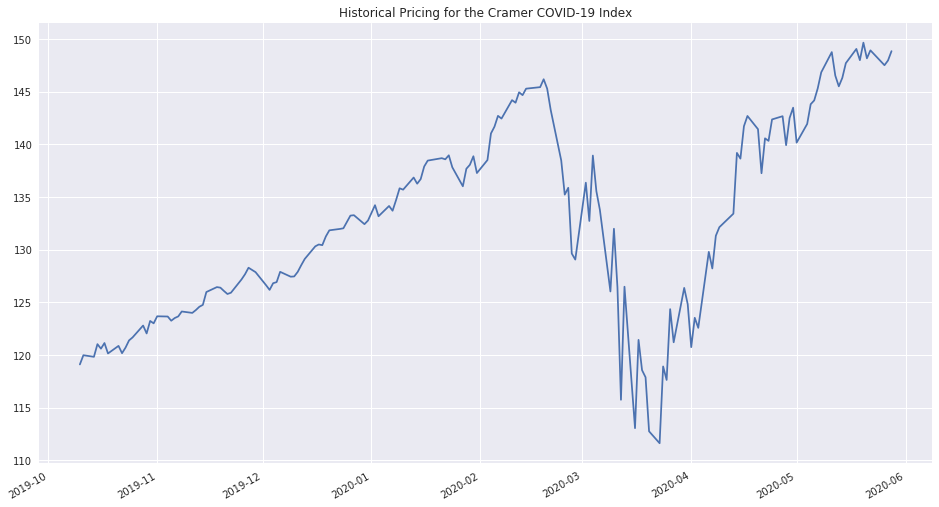

In [32]:
title_string = 'Historical Pricing for the Cramer COVID-19 Index'
index_df['JC_MAD'].plot(figsize=(16,9), title=title_string)
plt.show()

In [33]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3. Develop Strategy and Train Model

In [34]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
# Specify the parameters for the trading strategy
fast_ma = 10
slow_ma = 25

In [36]:
def ma_crossover(data):
    wait_for_entry = True
    for x in range(len(data)):
        if data['ma_change'].iloc[x] > 0:
            data['signal'].iloc[x] = 1  # Signal = 1 means we should take a long position
        else:
            data['signal'].iloc[x] = 0  # Signal = 0 means we should not have a position
        if x != 0:
            data['signal_chg'].iloc[x] = data['signal'].iloc[x] - data['signal'].iloc[x-1]
            if wait_for_entry and (data['signal_chg'].iloc[x-1] == 1):
                data['entry_exit'].iloc[x] = data['signal_chg'].iloc[x-1]
                wait_for_entry = False
            elif (not wait_for_entry) and (data['signal_chg'].iloc[x-1] != 0):
                data['entry_exit'].iloc[x] = data['signal_chg'].iloc[x-1]

In [38]:
model_collection = {}

for ticker in stock_list:
    print('Processing trading model for ticker symbol:', ticker)
    model_collection[ticker] = pd.DataFrame(stock_close_df[ticker])
    model_collection[ticker].rename(columns={ticker: 'close'}, inplace=True)
    model_collection[ticker]['open'] = stock_open_df[ticker]
    model_collection[ticker]['fast_ma'] = model_collection[ticker]['close'].rolling(fast_ma).mean()
    model_collection[ticker]['slow_ma'] = model_collection[ticker]['close'].rolling(slow_ma).mean()
    model_collection[ticker]['ma_change'] = model_collection[ticker]['fast_ma'] - model_collection[ticker]['slow_ma']
    model_collection[ticker]['signal'] = np.zeros(len(model_collection[ticker]))
    model_collection[ticker]['signal_chg'] = np.zeros(len(model_collection[ticker]))
    model_collection[ticker]['entry_exit'] = np.zeros(len(model_collection[ticker]))
    model_collection[ticker] = model_collection[ticker][model_start_date:model_end_date]
    if verbose:
        print(model_collection[ticker].head())
        print('...')
        print(model_collection[ticker].tail())
        print()
    ma_crossover(model_collection[ticker])

Processing trading model for ticker symbol: AAPL
Processing trading model for ticker symbol: ABBV
Processing trading model for ticker symbol: ABT
Processing trading model for ticker symbol: ADBE
Processing trading model for ticker symbol: AKAM
Processing trading model for ticker symbol: AMD
Processing trading model for ticker symbol: AMT
Processing trading model for ticker symbol: AMZN
Processing trading model for ticker symbol: ATVI
Processing trading model for ticker symbol: BAX
Processing trading model for ticker symbol: BNTX
Processing trading model for ticker symbol: BSX
Processing trading model for ticker symbol: BYND
Processing trading model for ticker symbol: CAG
Processing trading model for ticker symbol: CCI
Processing trading model for ticker symbol: CHGG
Processing trading model for ticker symbol: CHWY
Processing trading model for ticker symbol: CL
Processing trading model for ticker symbol: CLX
Processing trading model for ticker symbol: CMG
Processing trading model for ti

In [39]:
for ticker in stock_list:
    print('List the signal change and entry/exit points for', ticker)
    print(model_collection[ticker][(model_collection[ticker].signal_chg != 0) | (model_collection[ticker].entry_exit != 0)])
    print()

List the signal change and entry/exit points for AAPL
             close    open  fast_ma   slow_ma  ma_change  signal  signal_chg  entry_exit
2019-11-13  264.47  261.13  258.465  247.1044    11.3606     1.0         1.0         0.0
2019-11-14  262.64  263.75  259.853  248.4064    11.4466     1.0         0.0         1.0
2020-02-25  288.08  300.95  315.886  317.2312    -1.3452     0.0        -1.0         0.0
2020-02-26  292.65  286.53  313.190  316.2744    -3.0844     0.0         0.0        -1.0
2020-04-13  273.25  268.31  256.556  254.2964     2.2596     1.0         1.0         0.0
2020-04-14  287.05  280.00  259.780  255.1316     4.6484     1.0         0.0         1.0

List the signal change and entry/exit points for ABBV
            close   open  fast_ma  slow_ma  ma_change  signal  signal_chg  entry_exit
2019-11-13  86.66  85.74   83.419  79.1836     4.2354     1.0         1.0         0.0
2019-11-14  87.63  86.48   84.227  79.7108     4.5162     1.0         0.0         1.0
2019-12-13

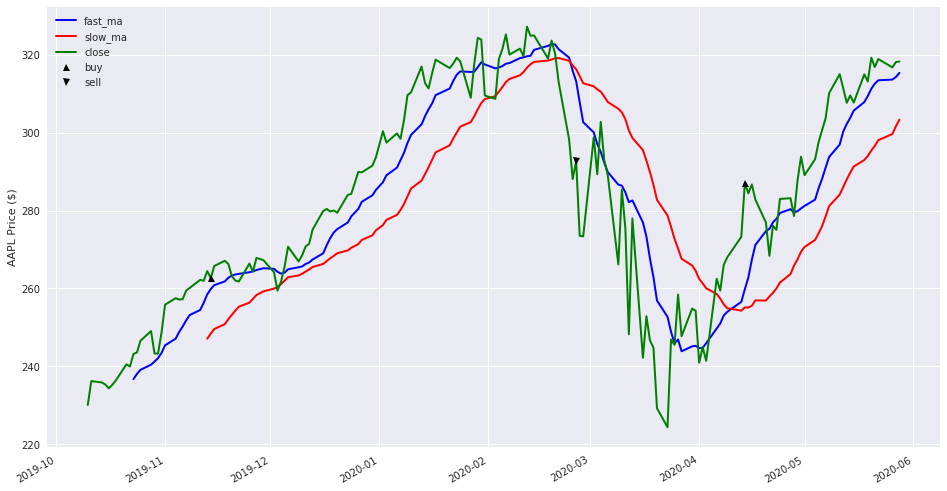

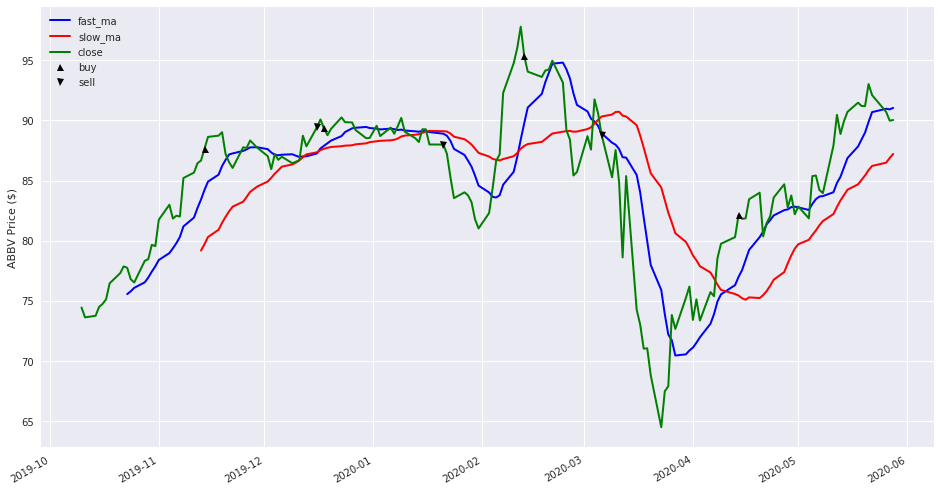

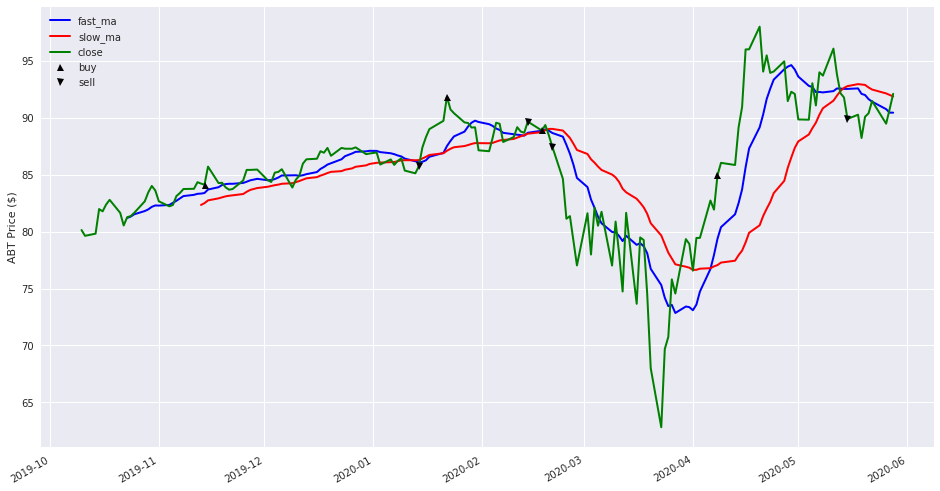

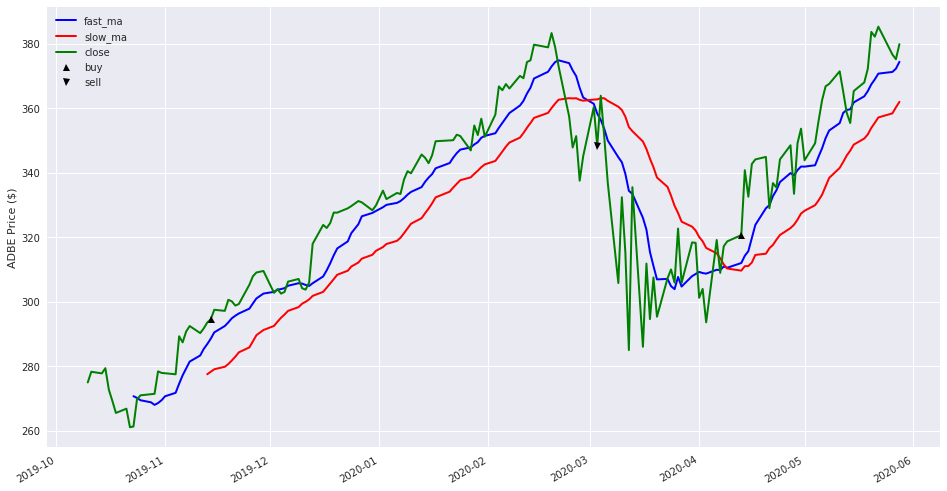

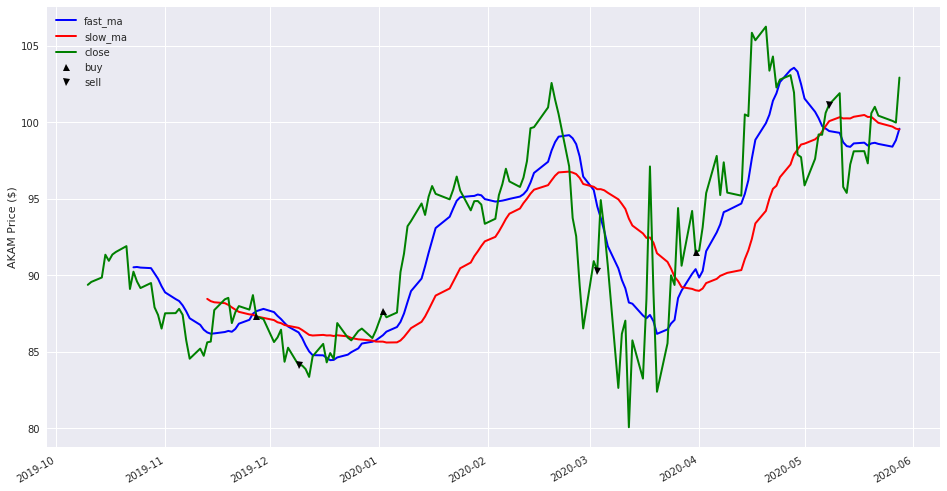

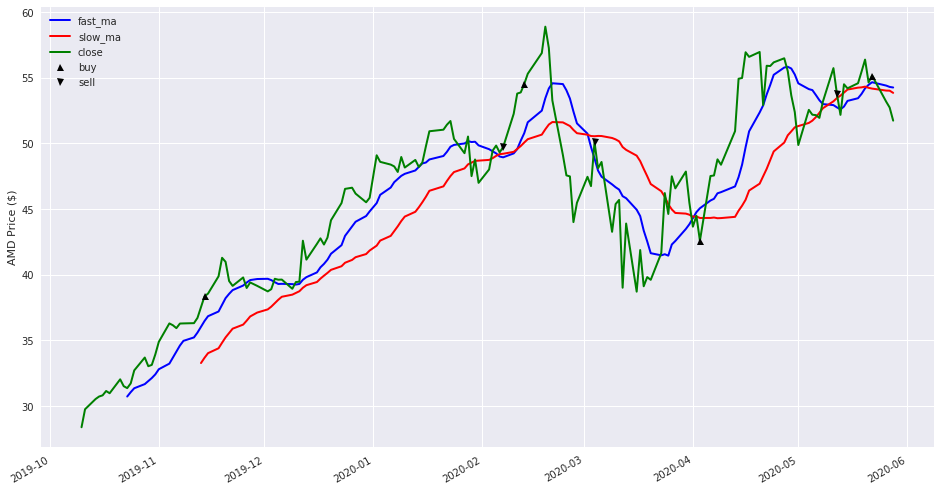

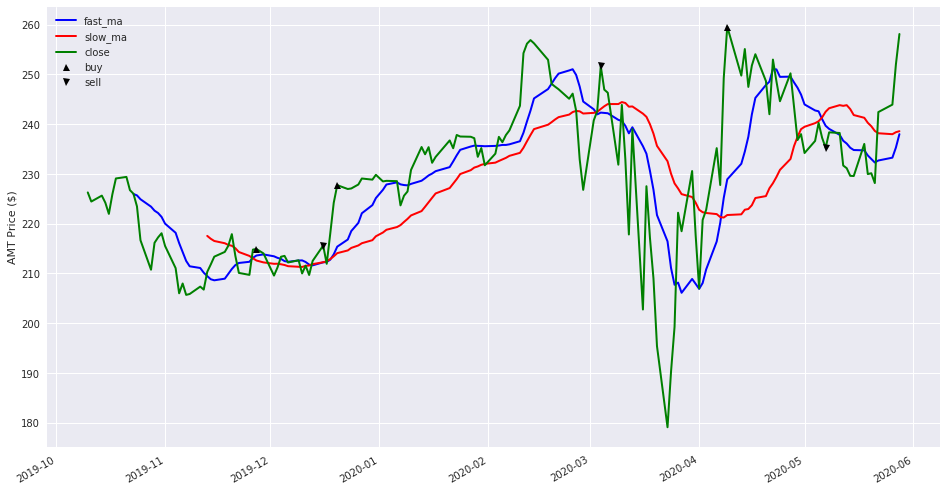

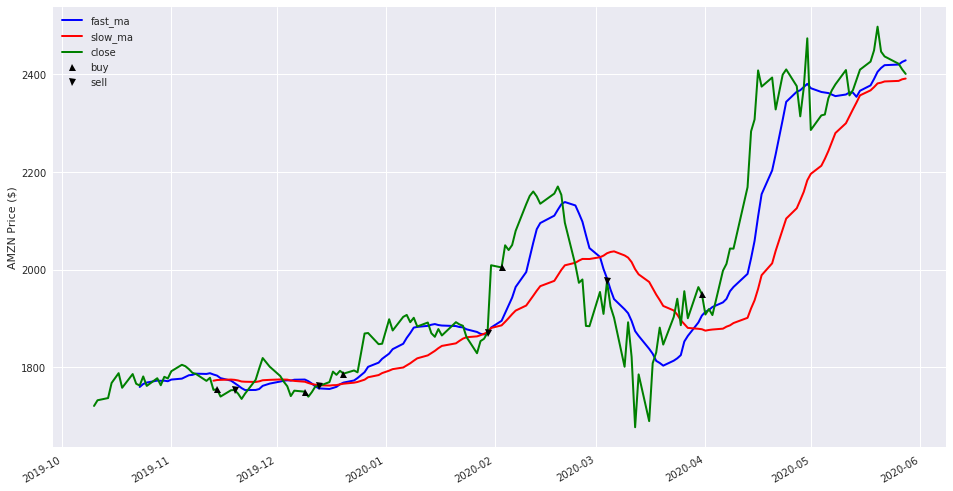

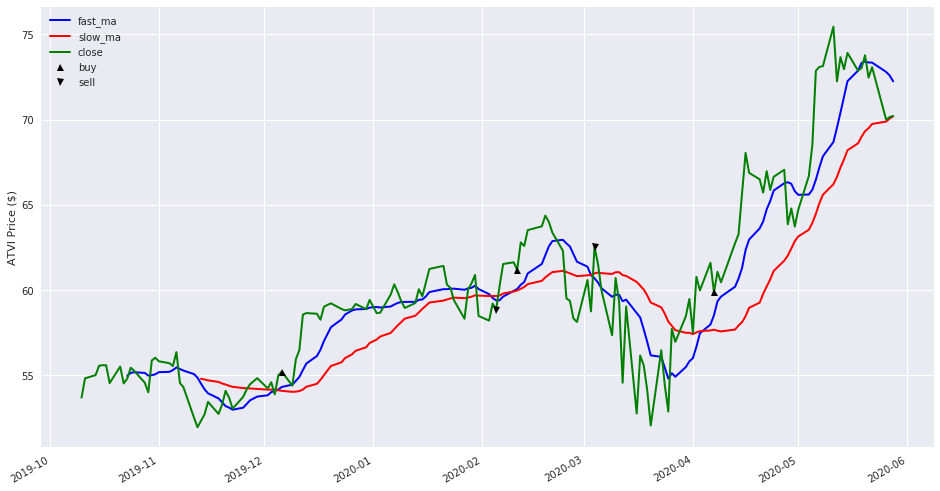

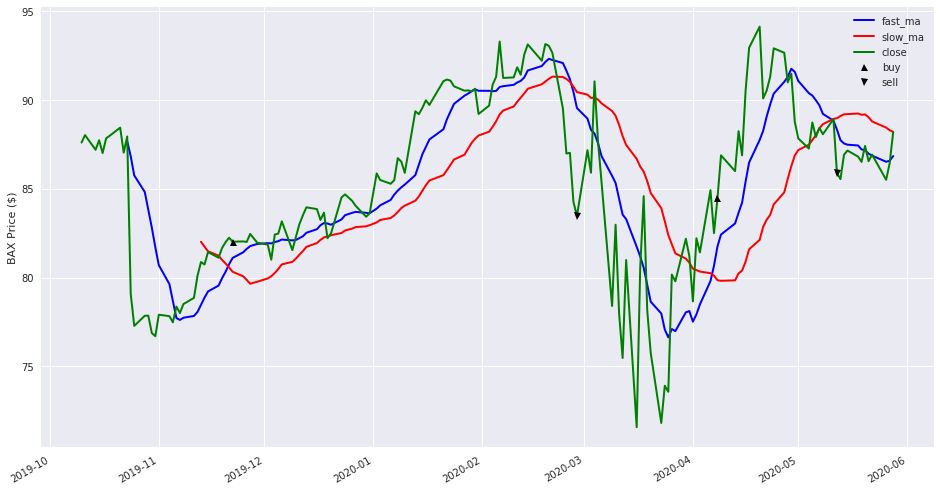

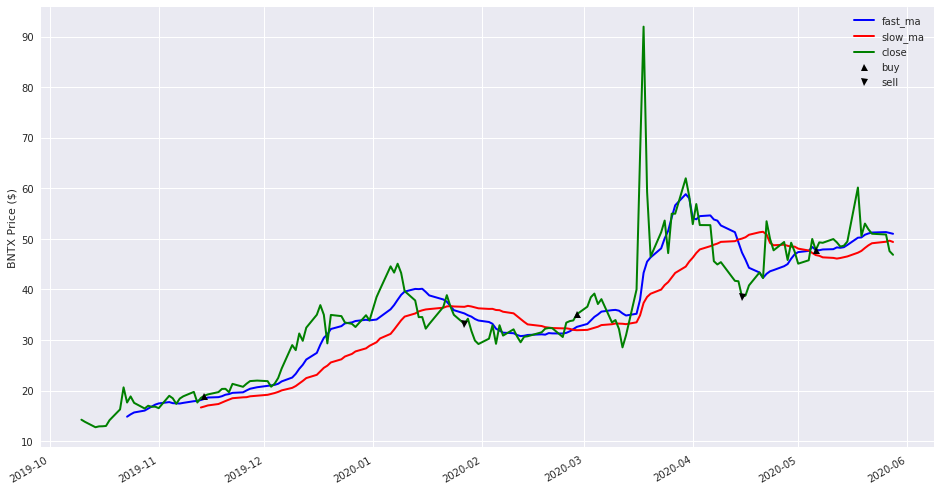

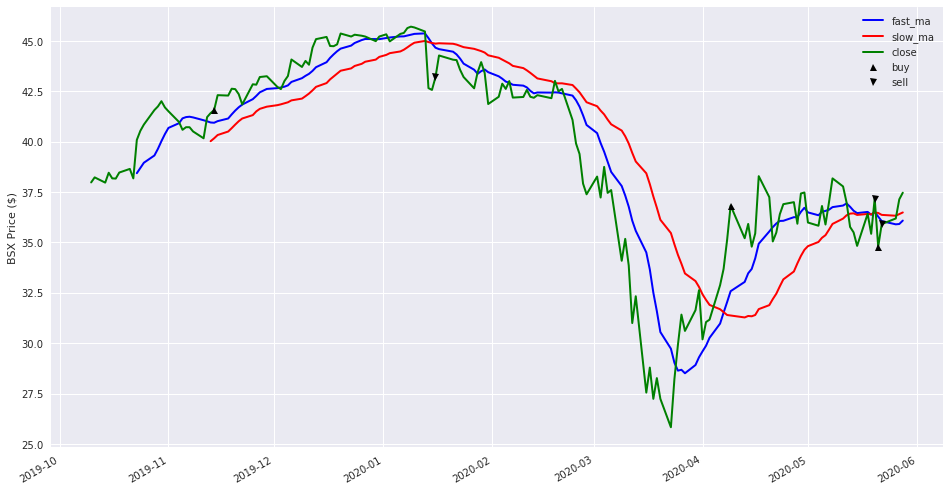

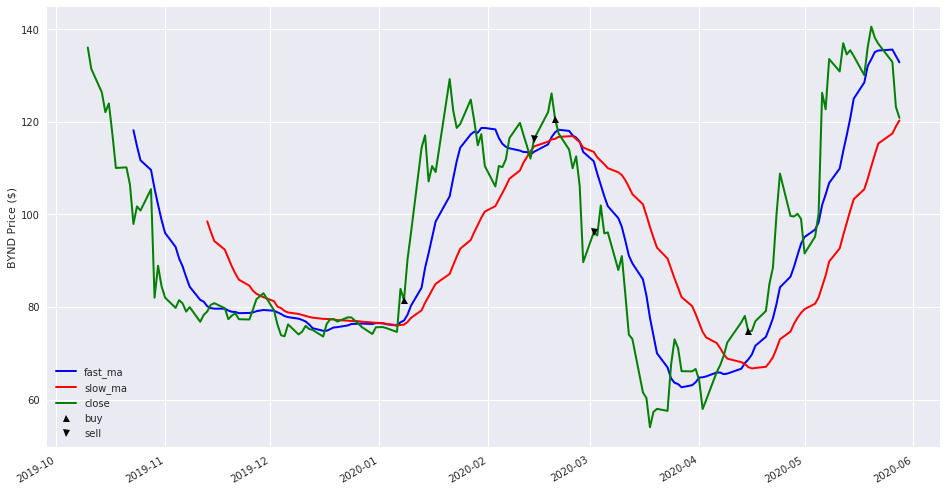

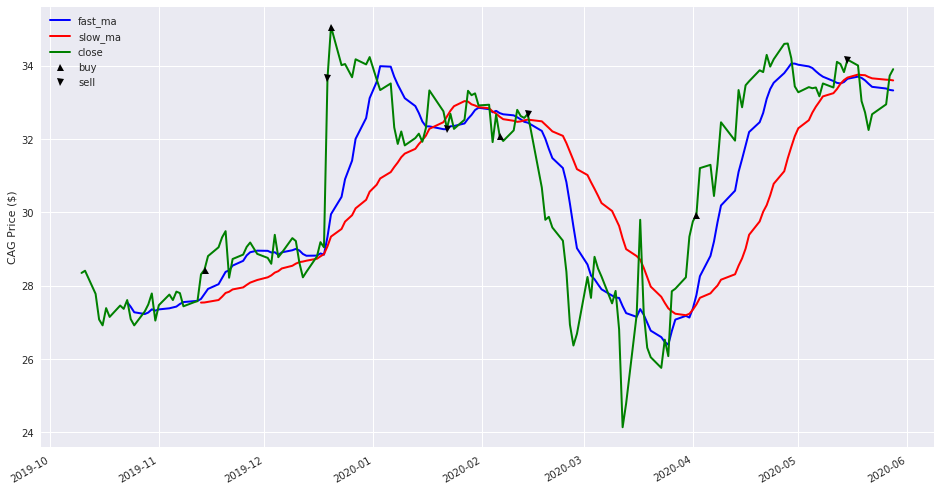

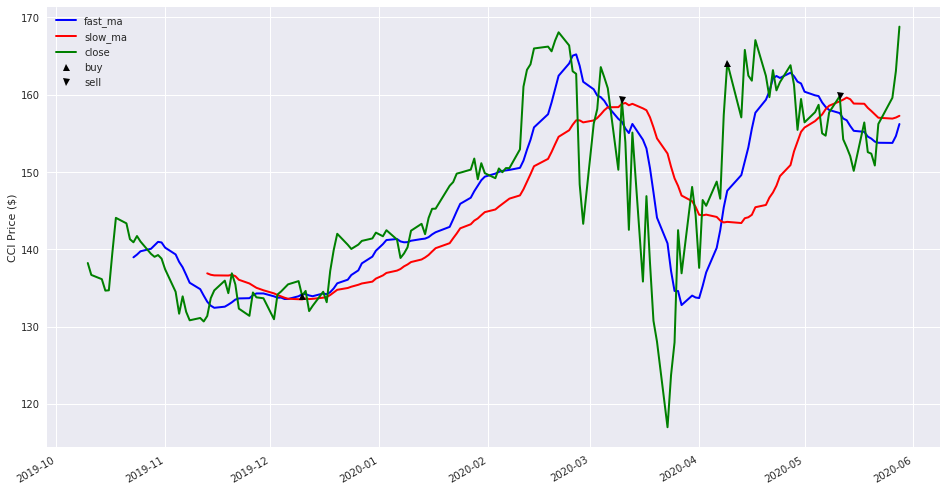

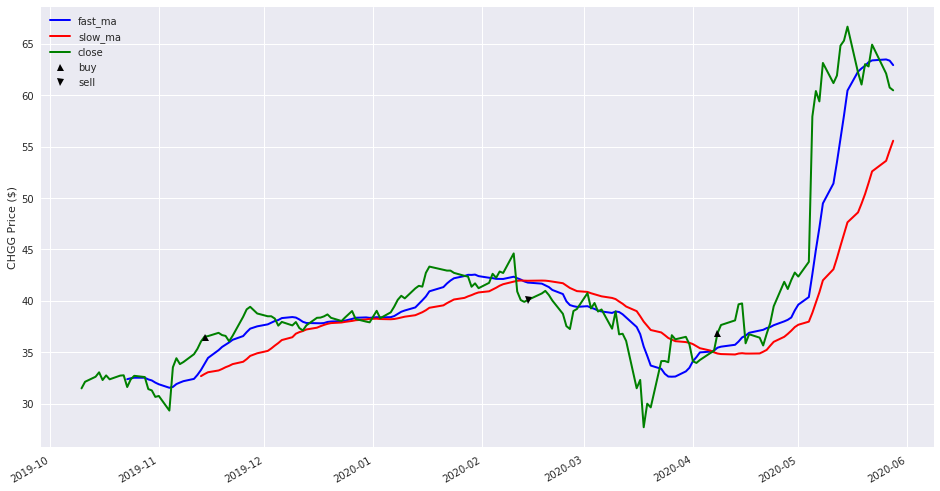

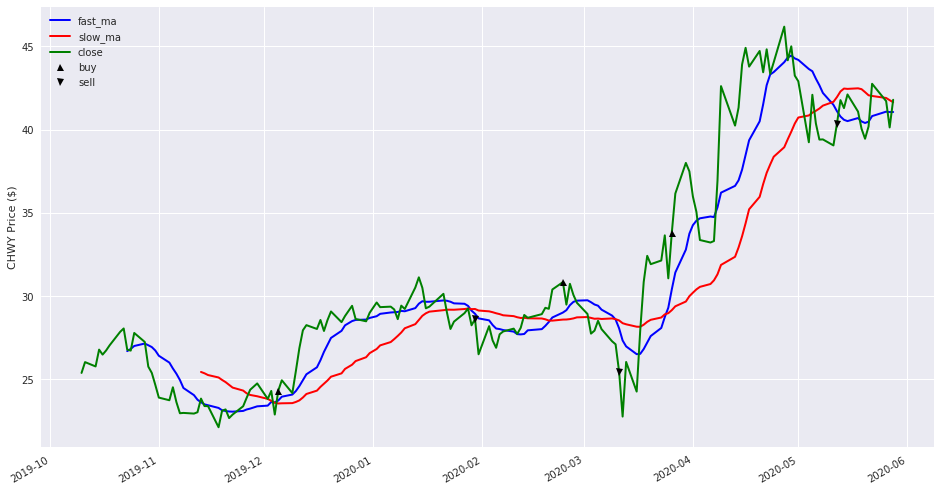

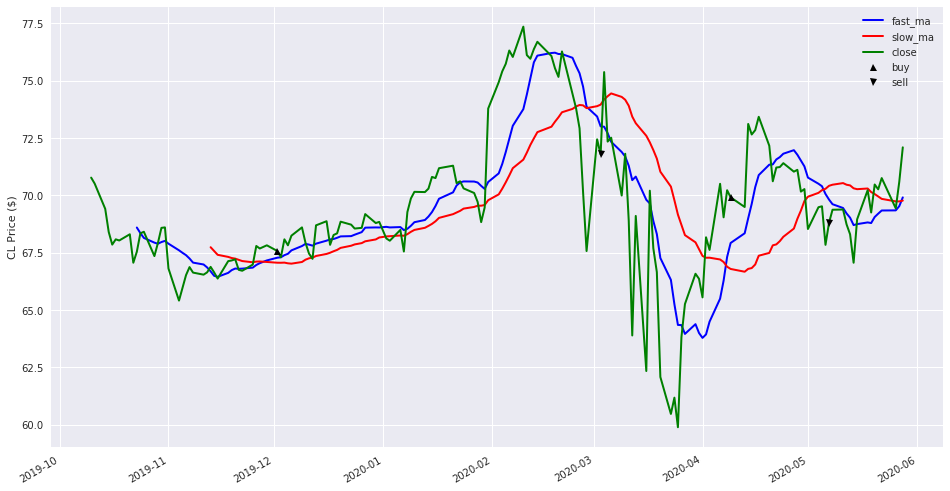

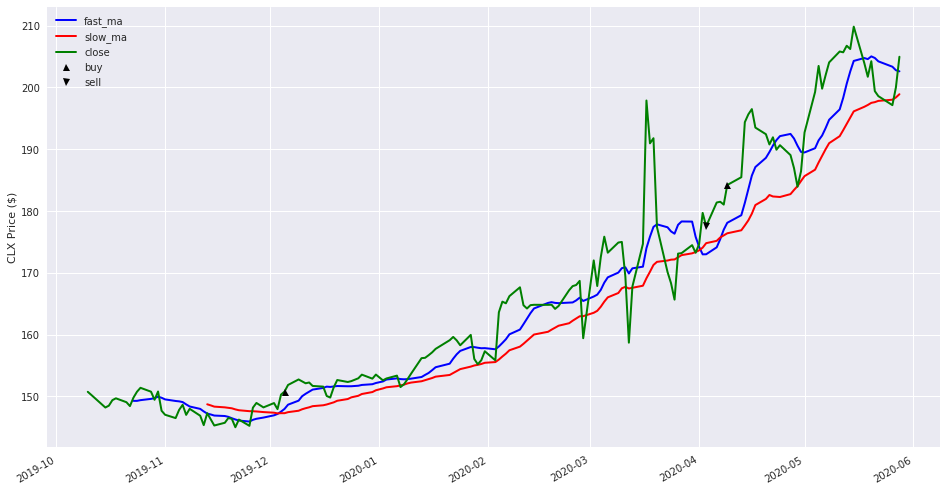

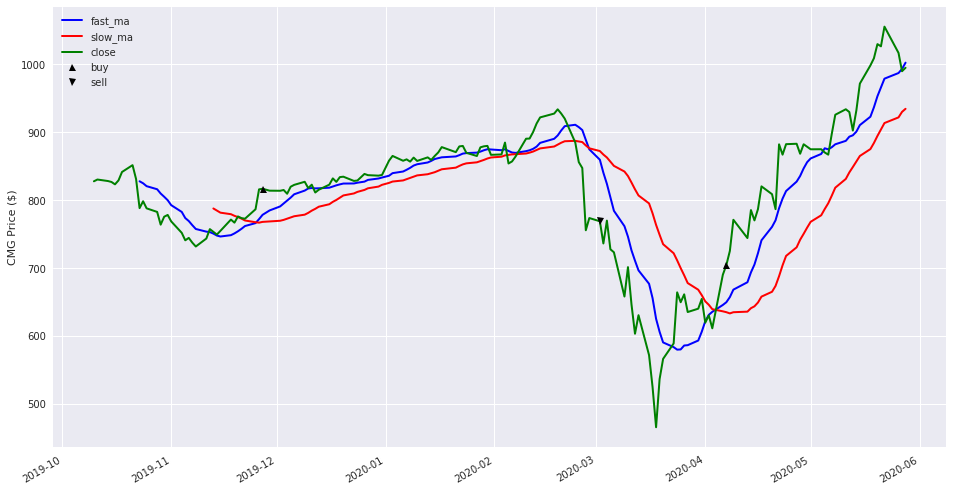

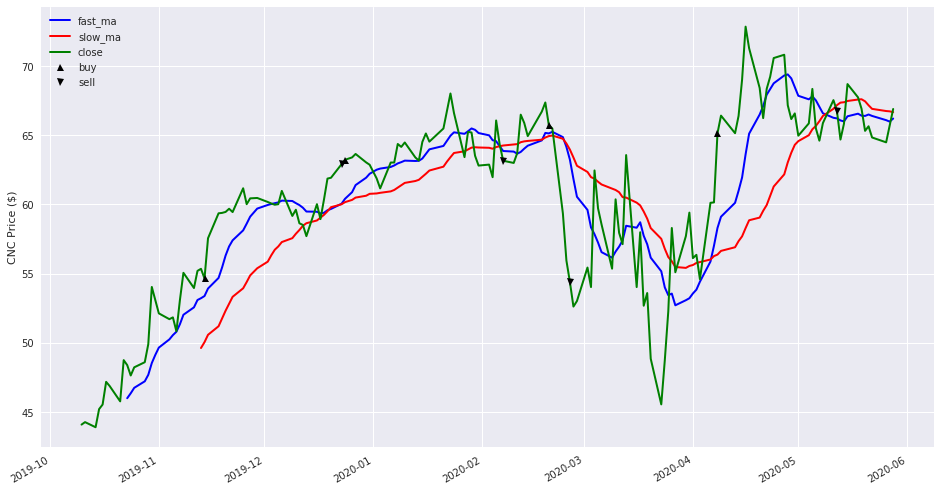

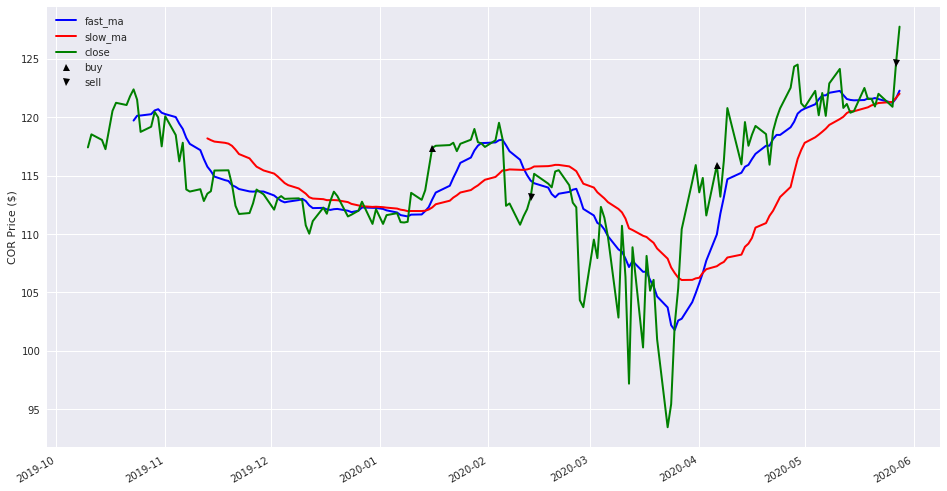

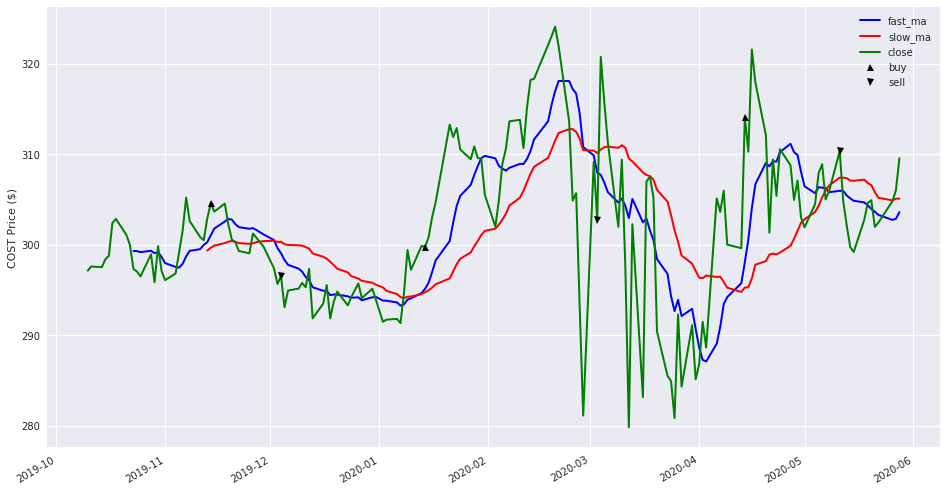

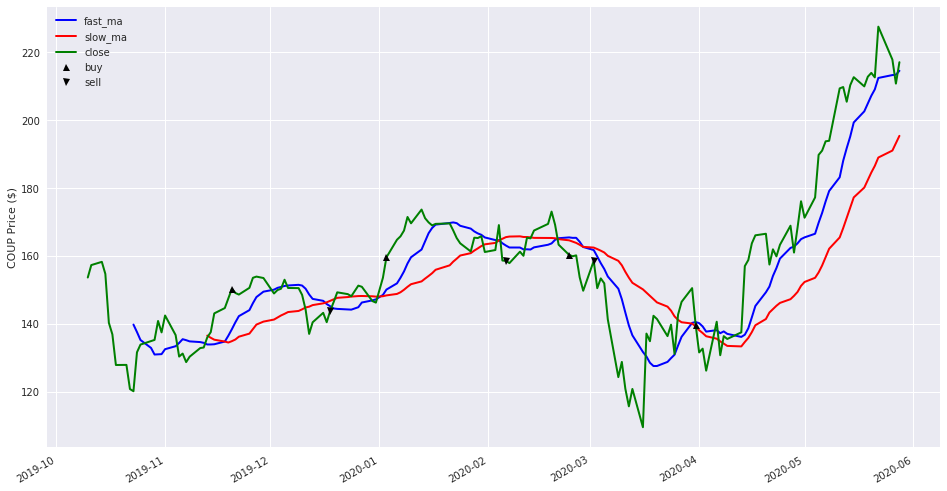

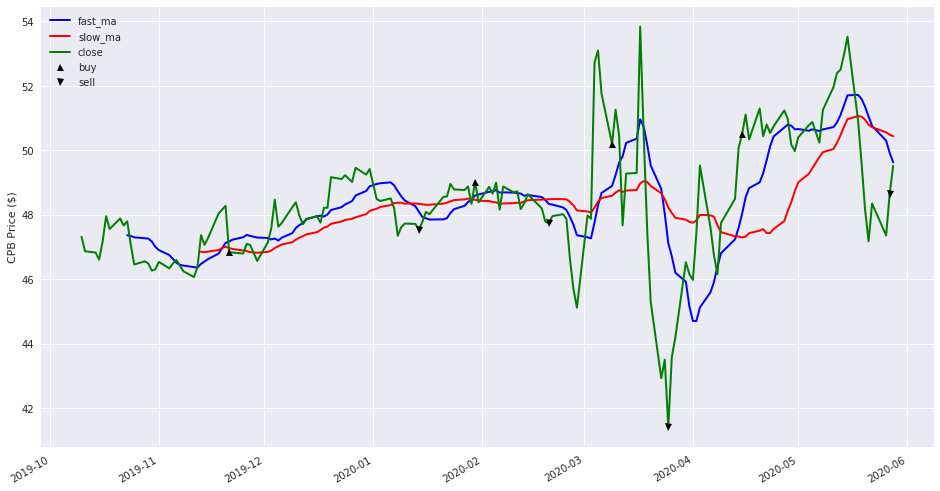

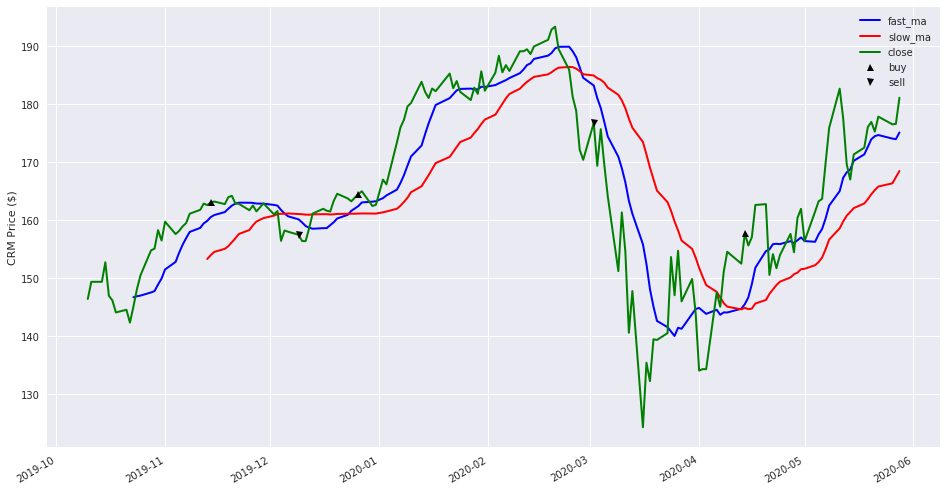

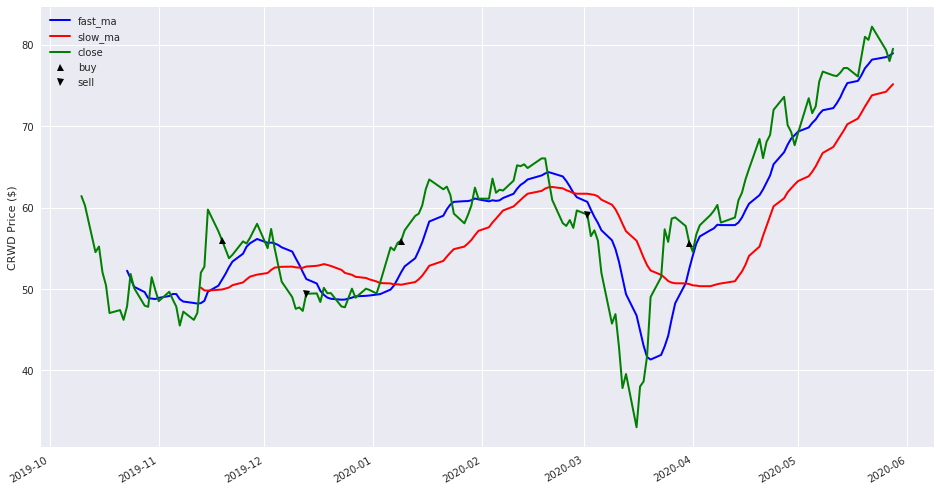

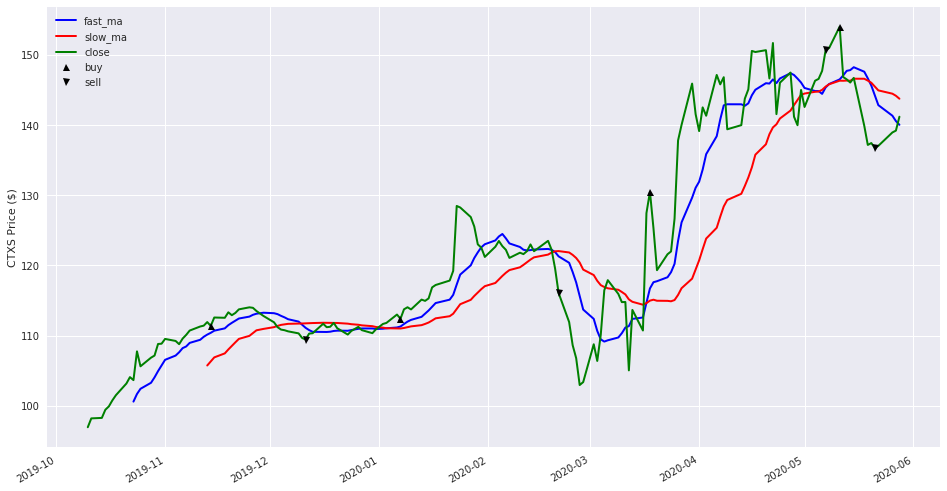

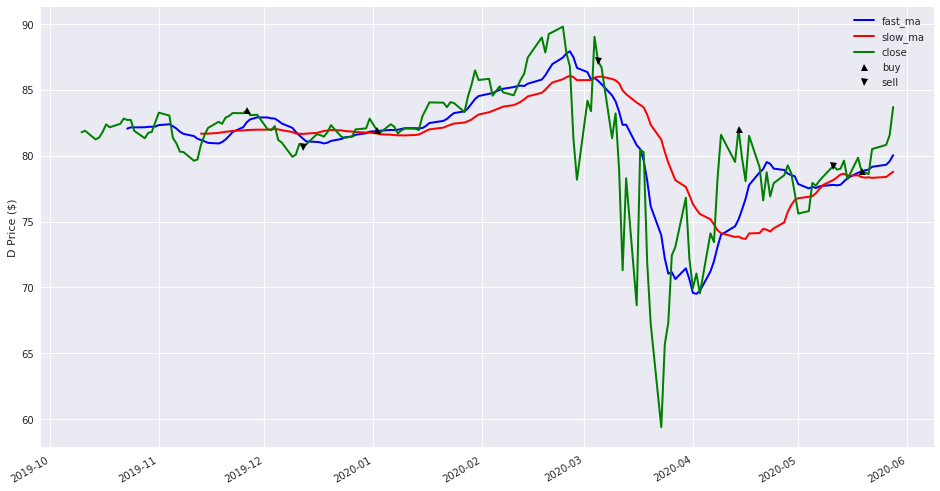

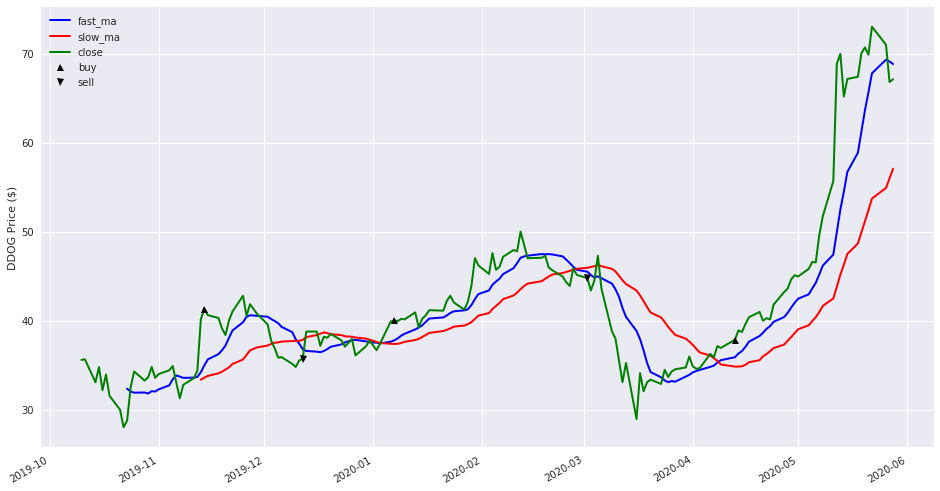

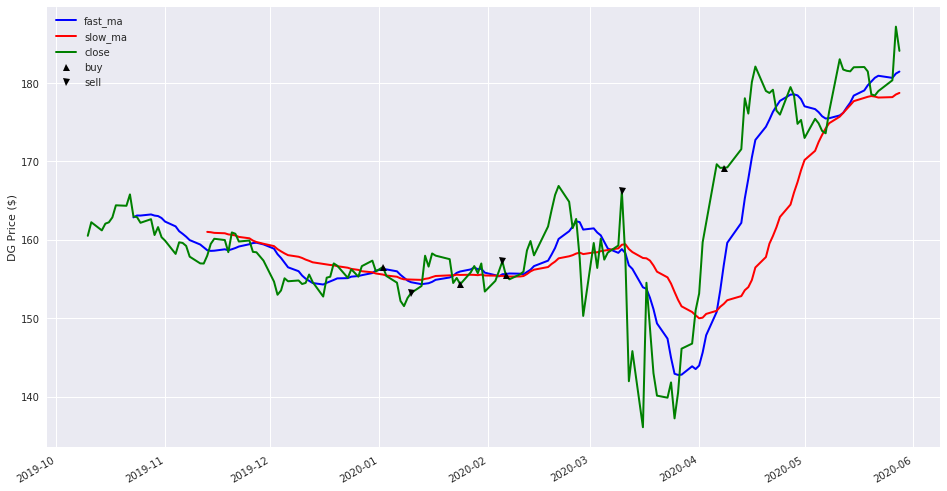

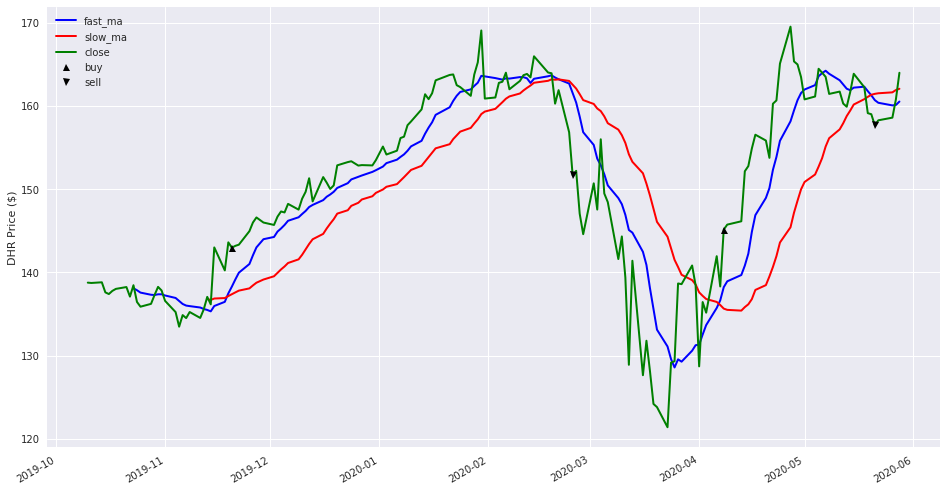

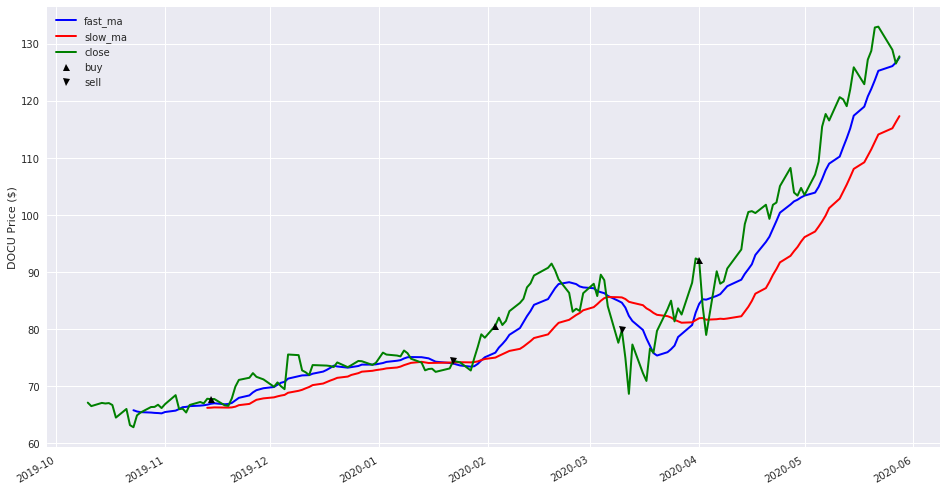

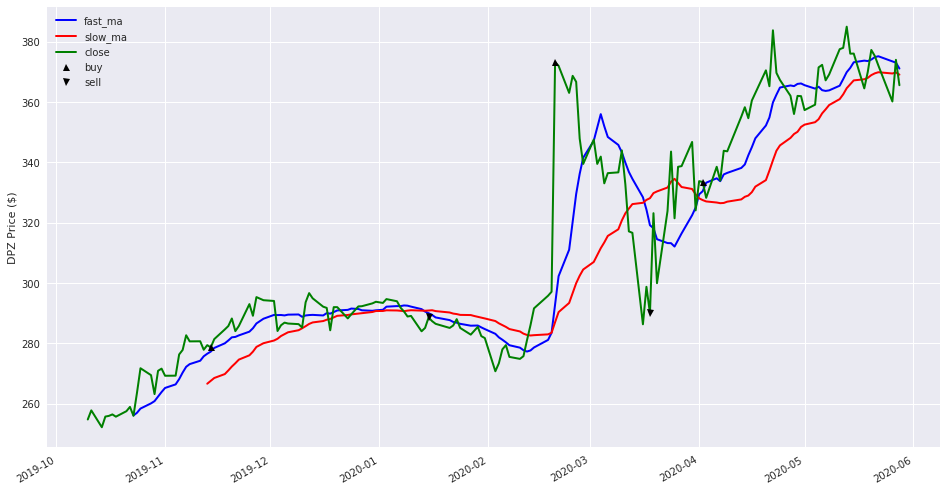

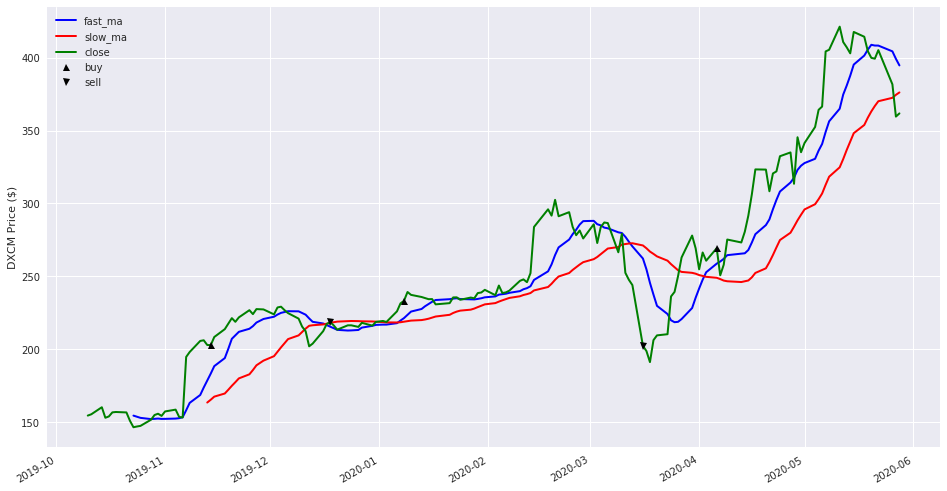

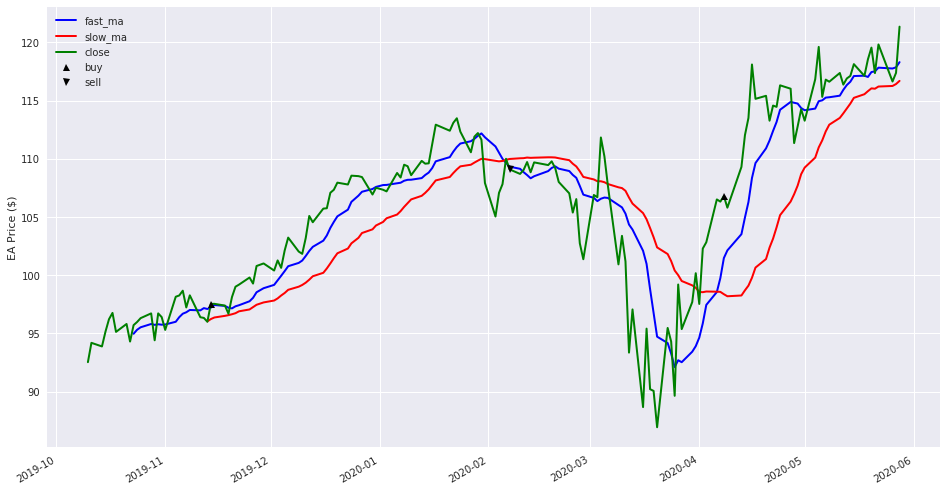

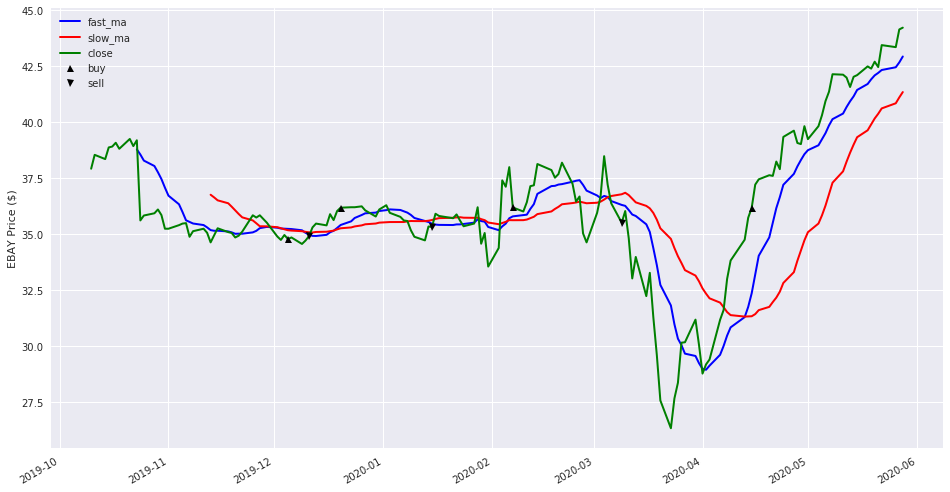

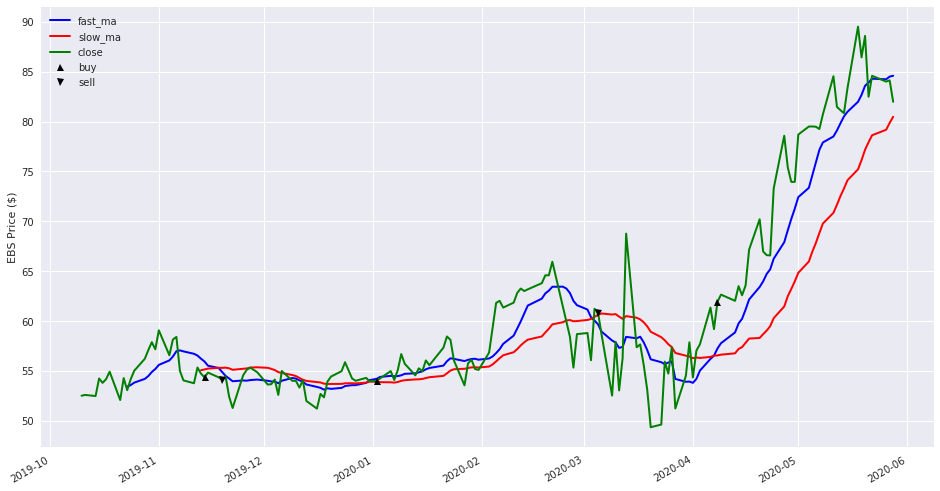

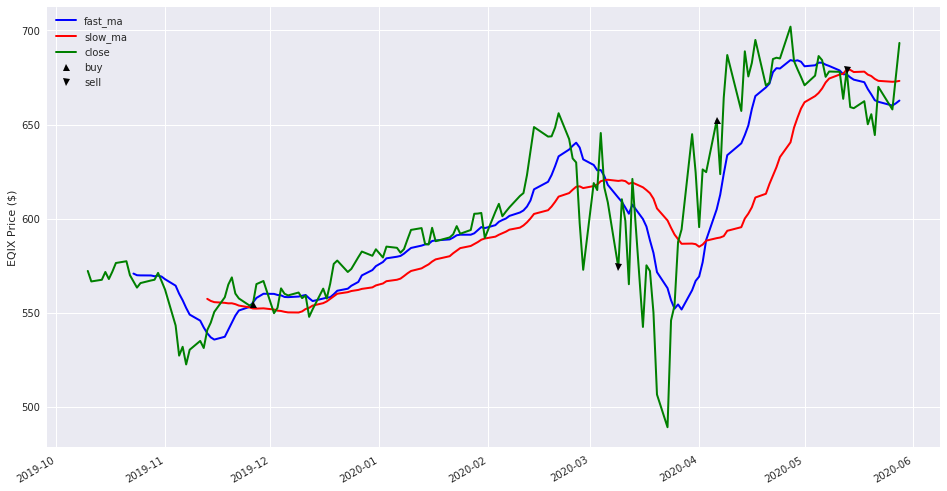

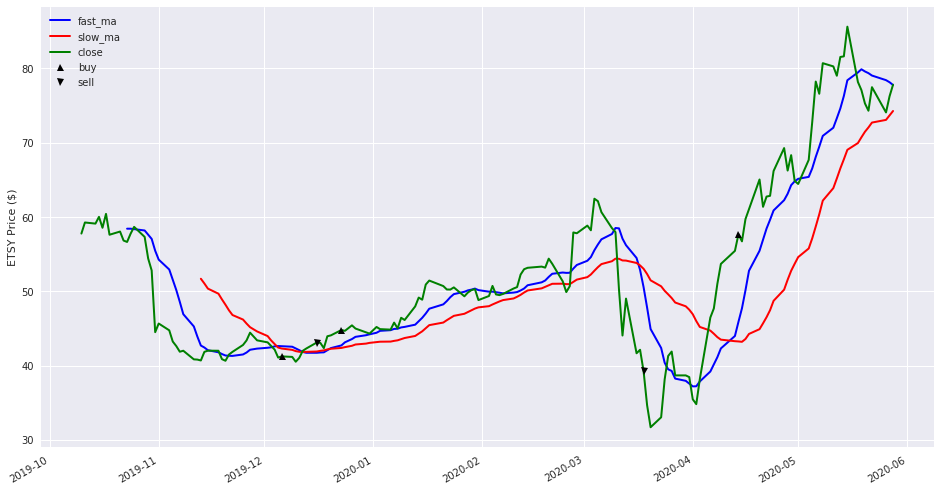

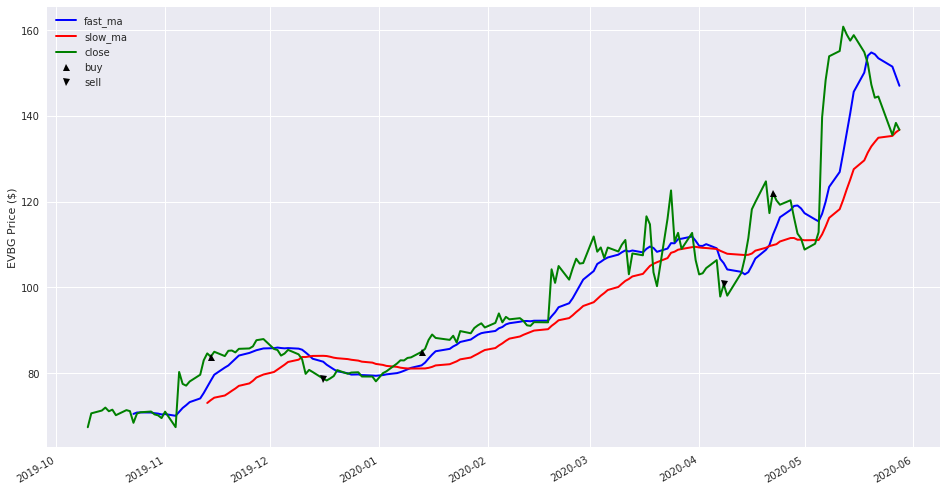

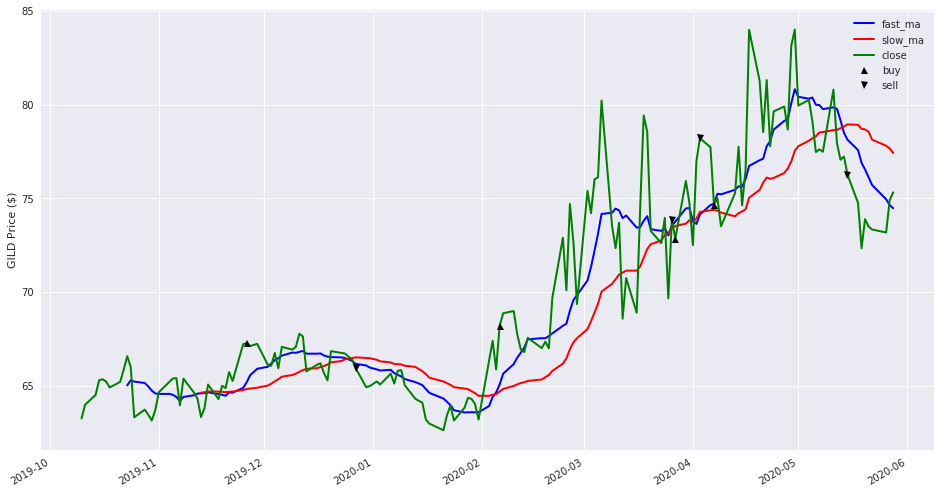

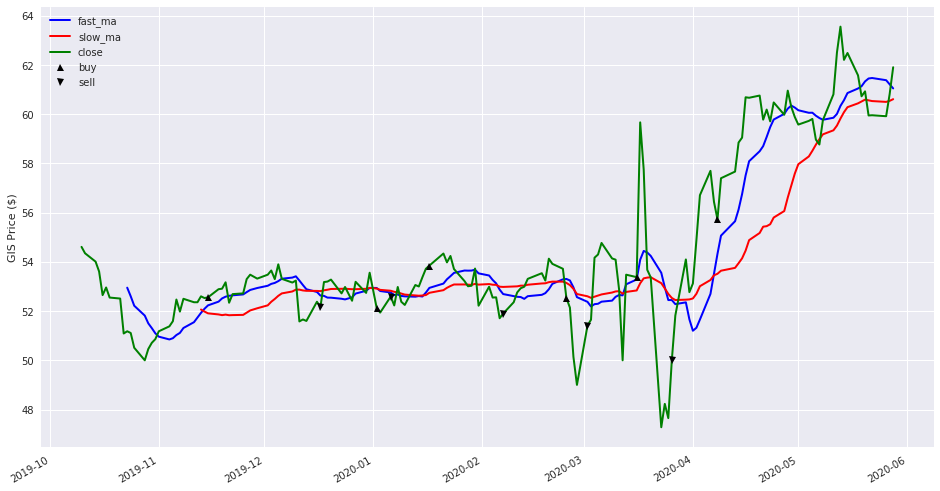

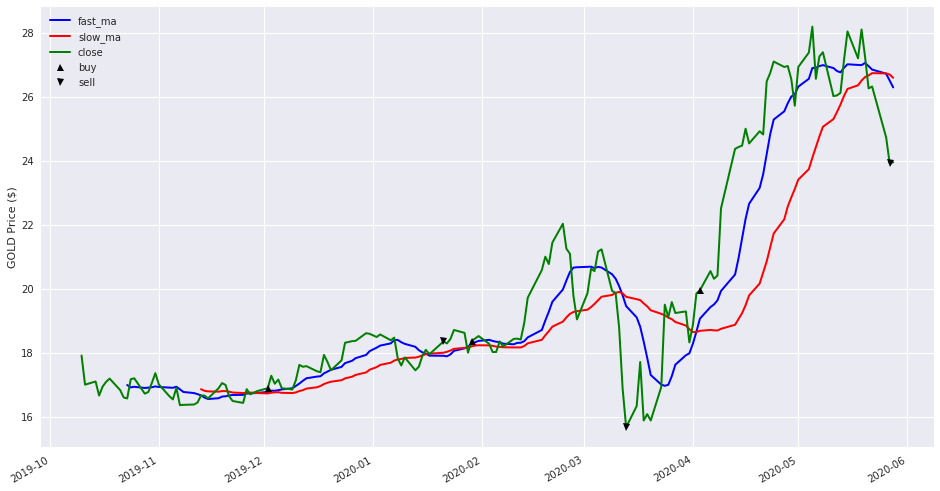

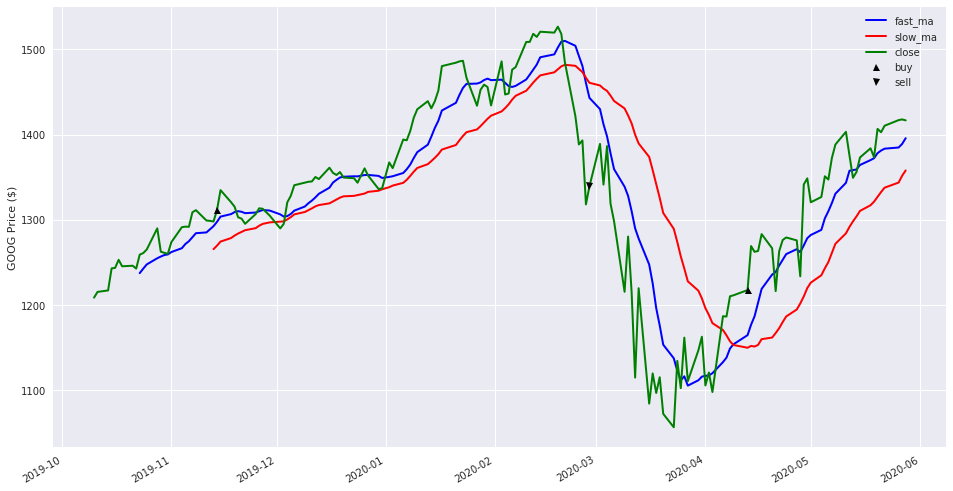

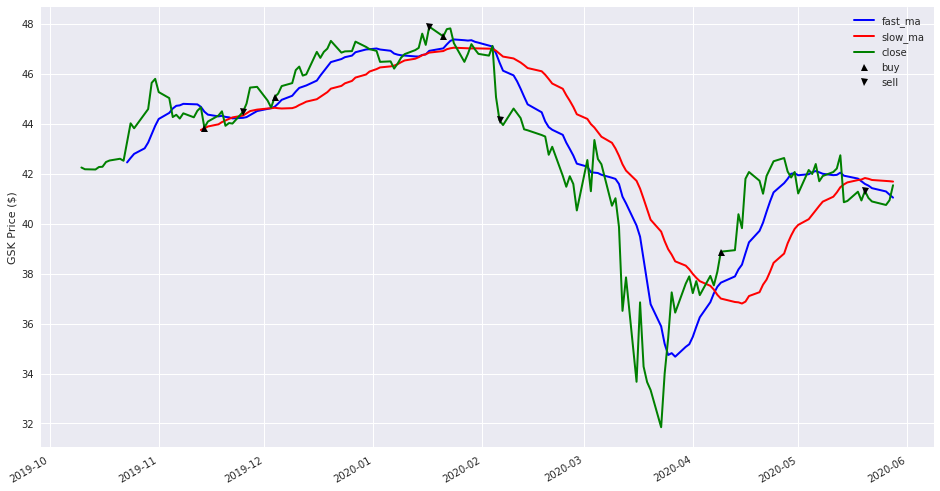

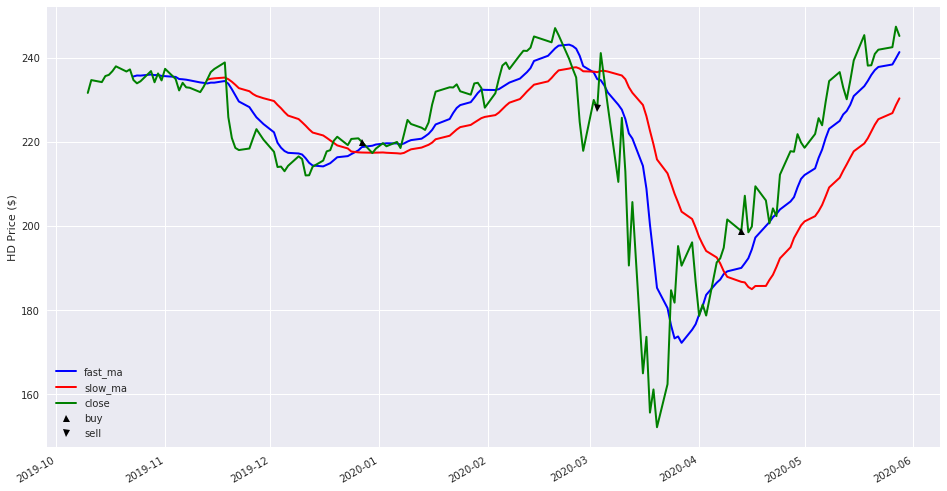

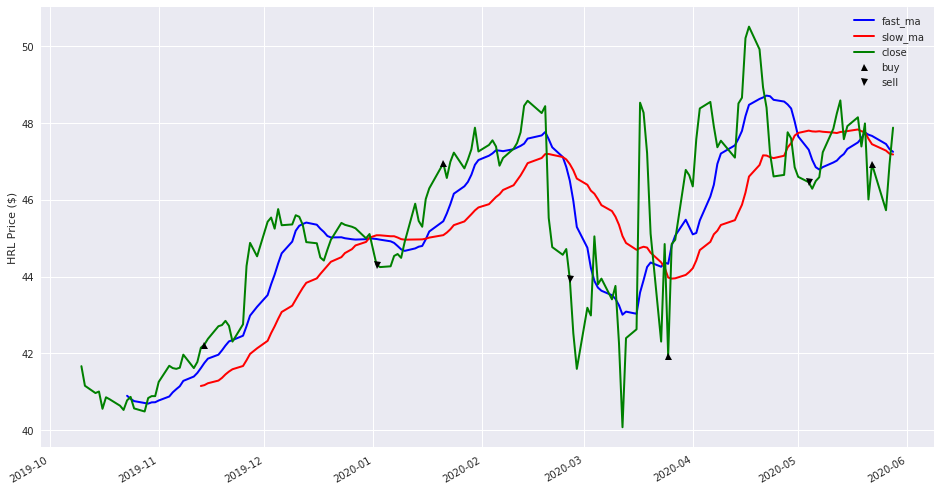

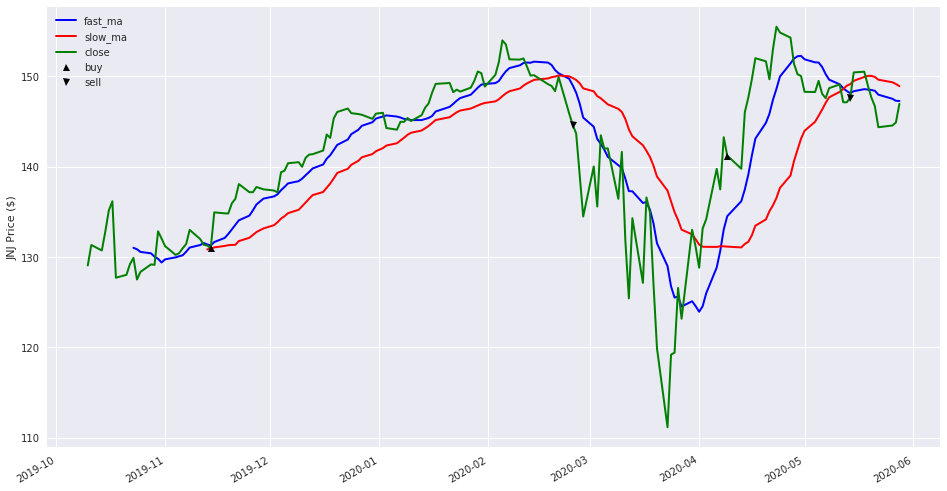

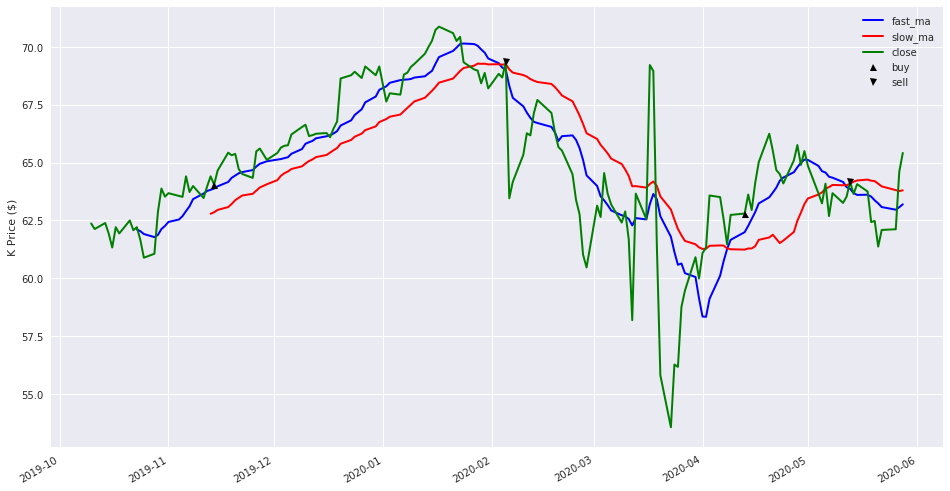

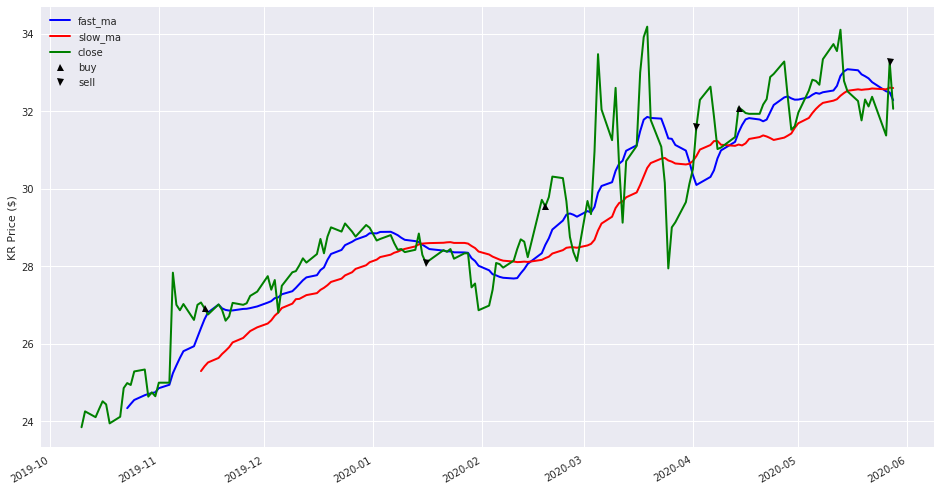

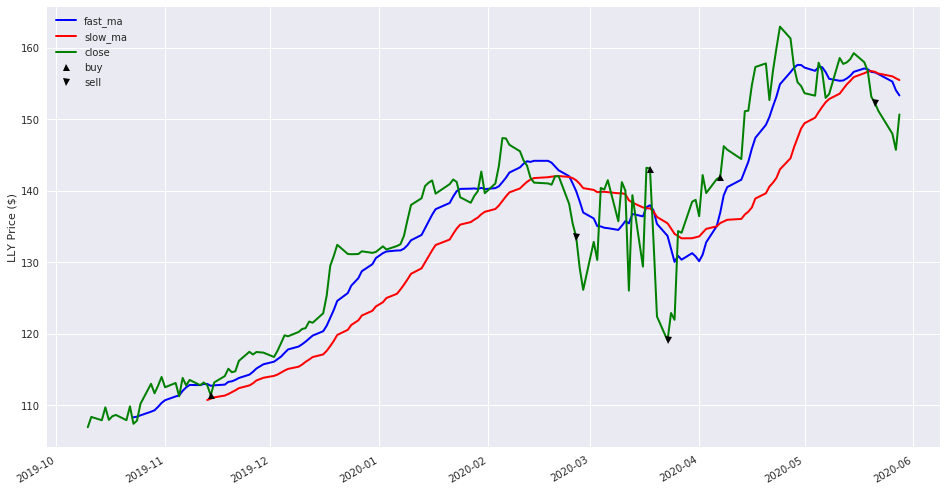

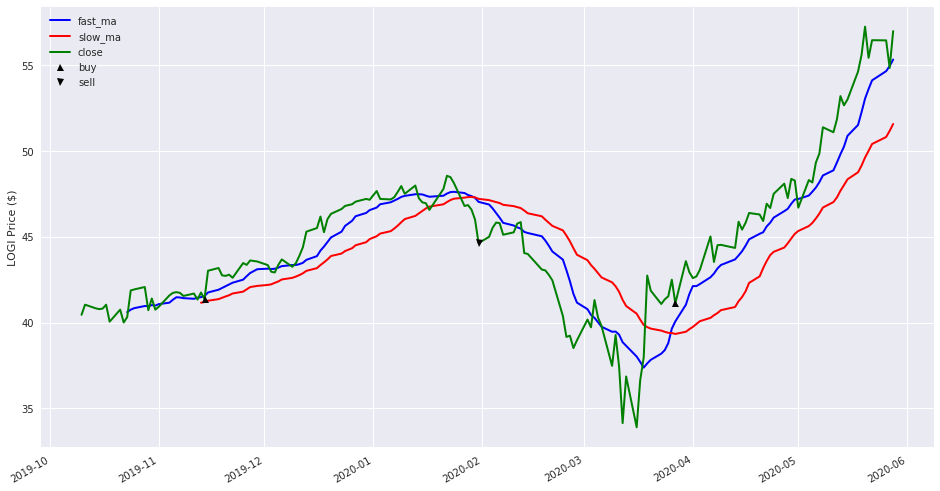

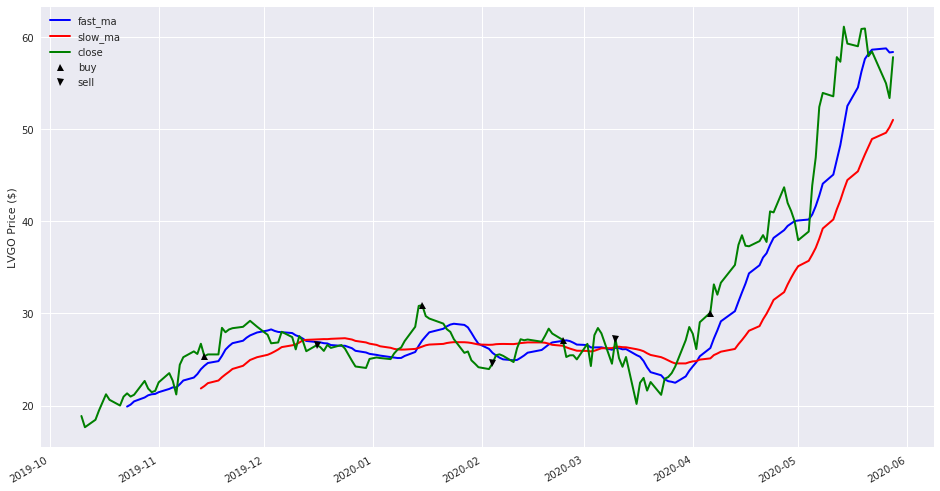

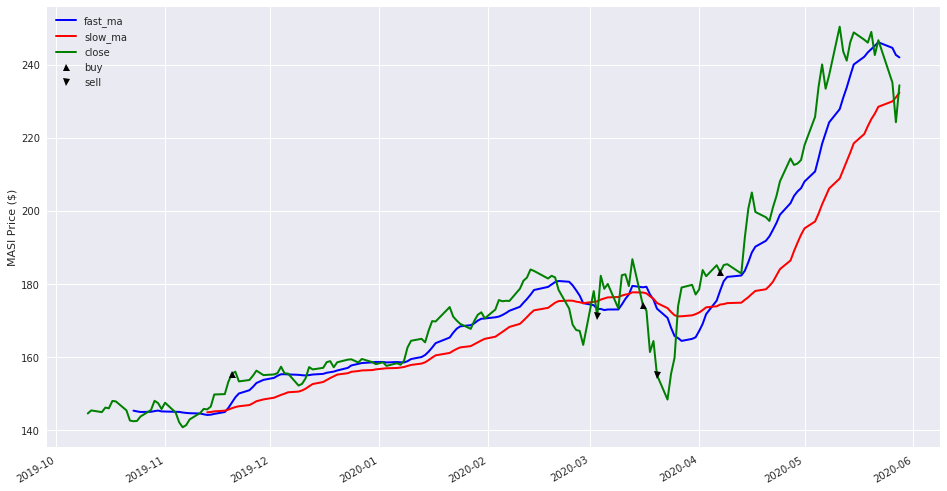

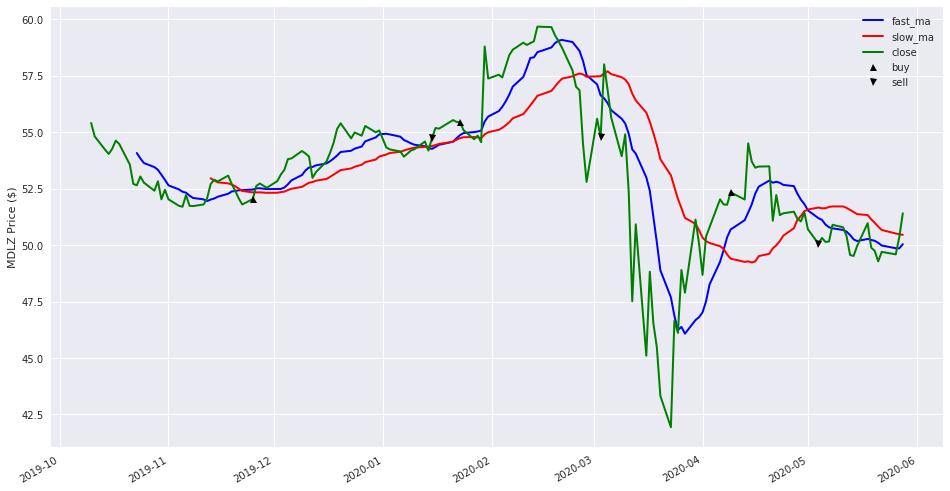

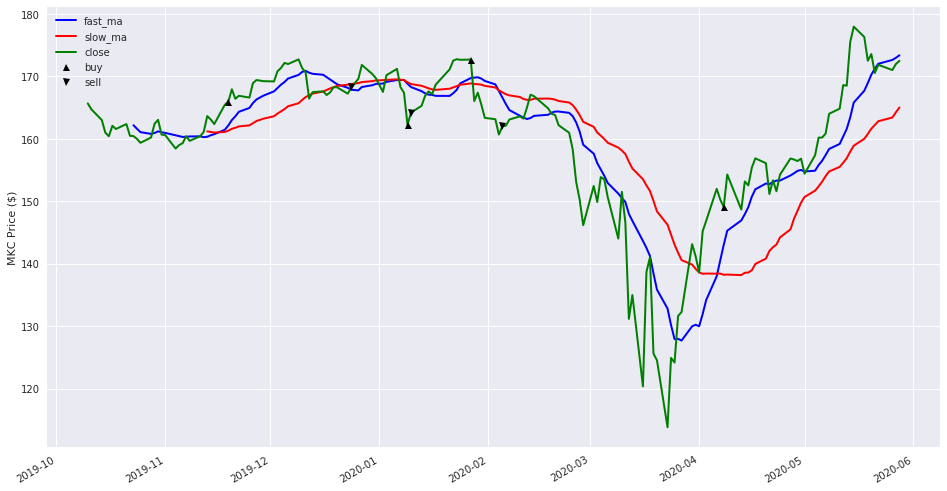

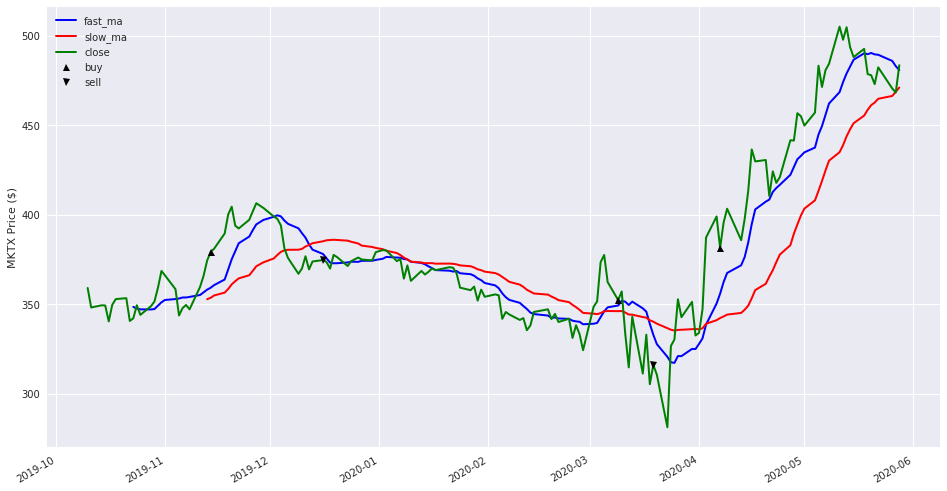

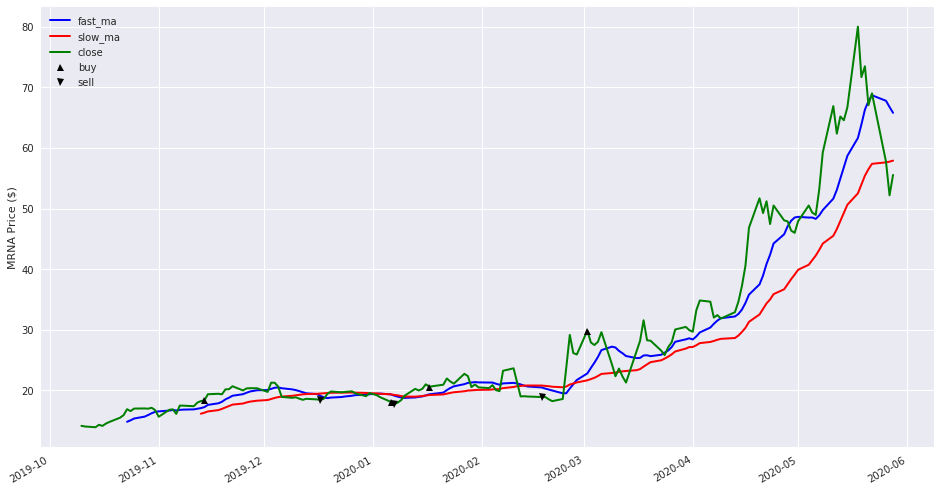

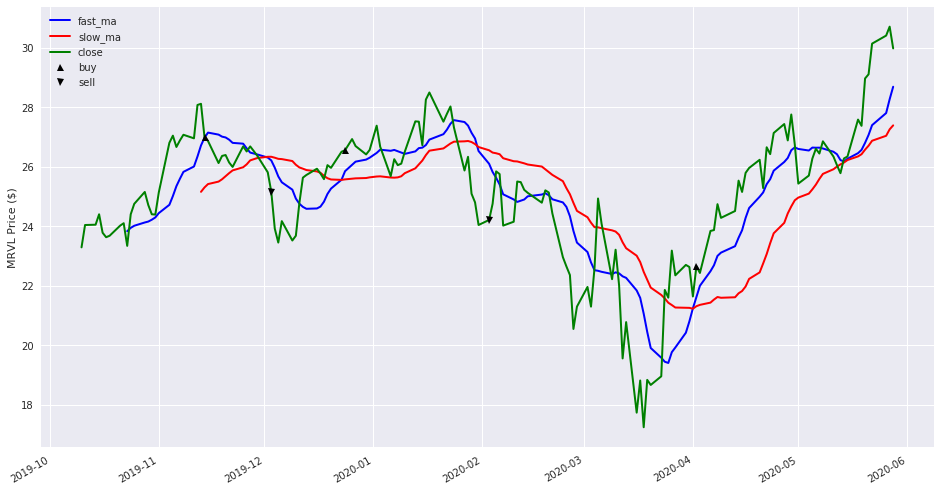

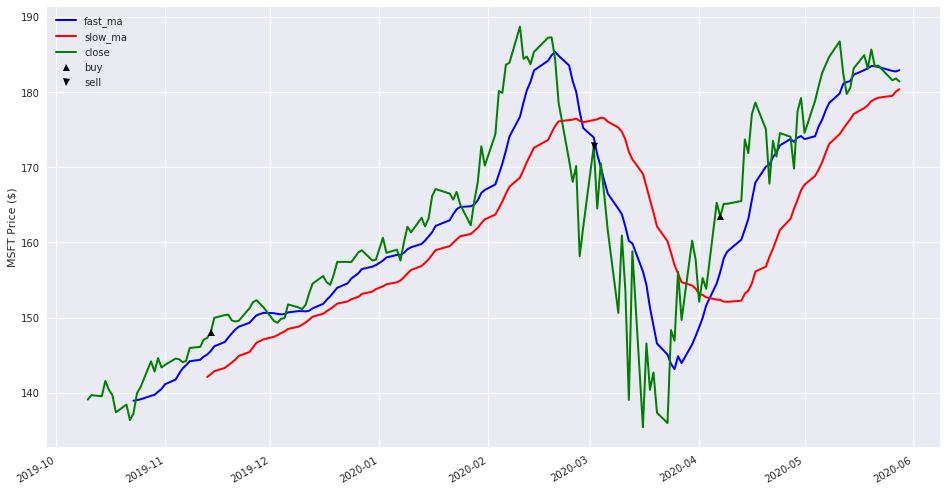

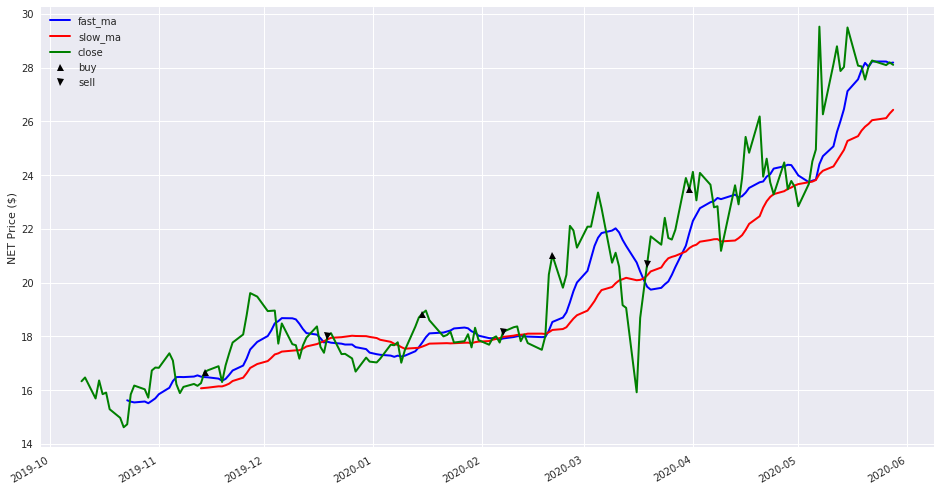

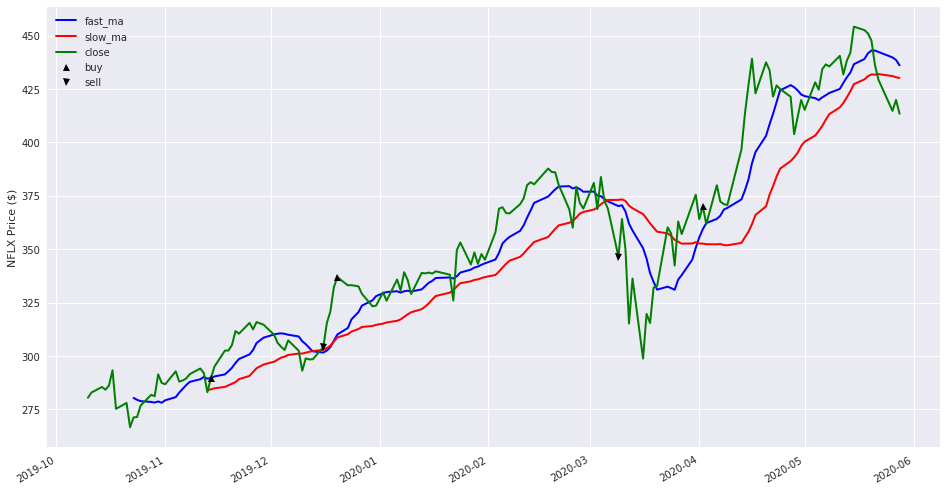

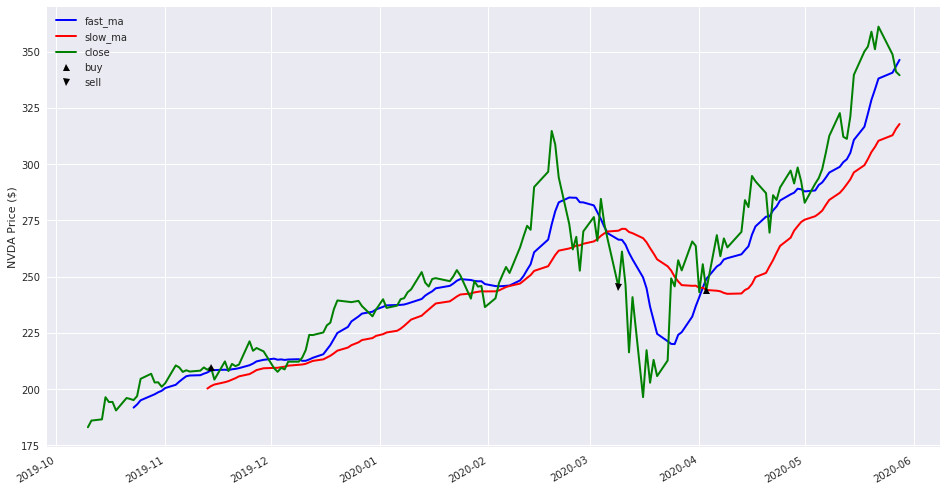

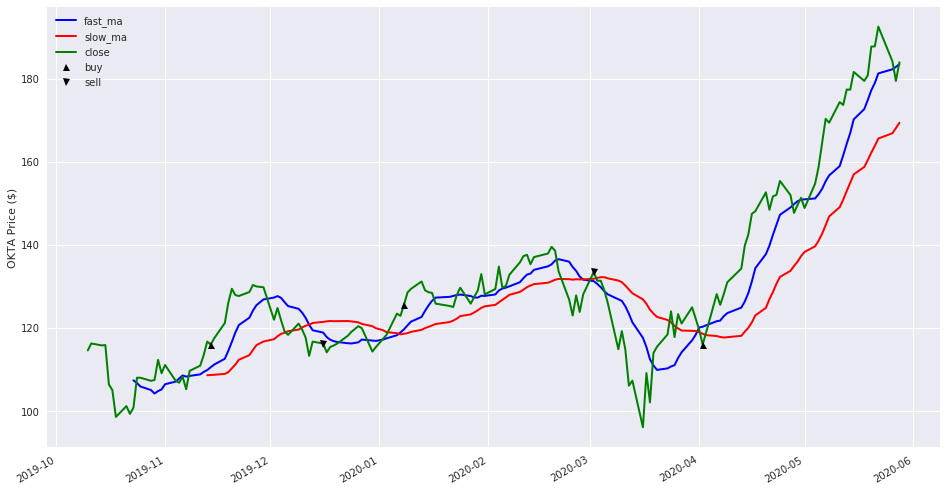

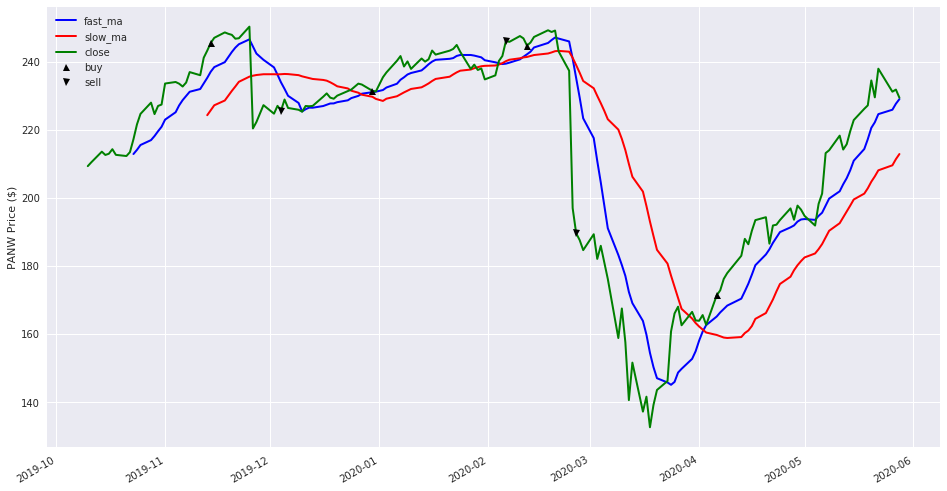

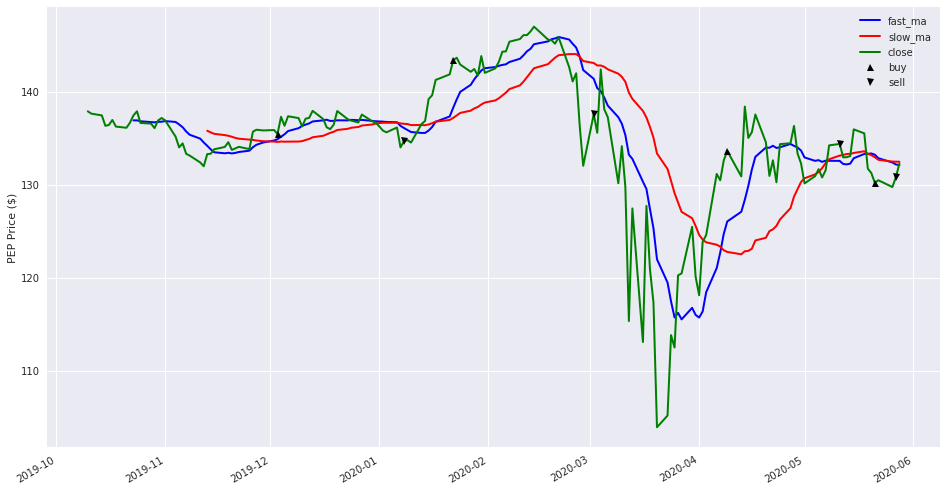

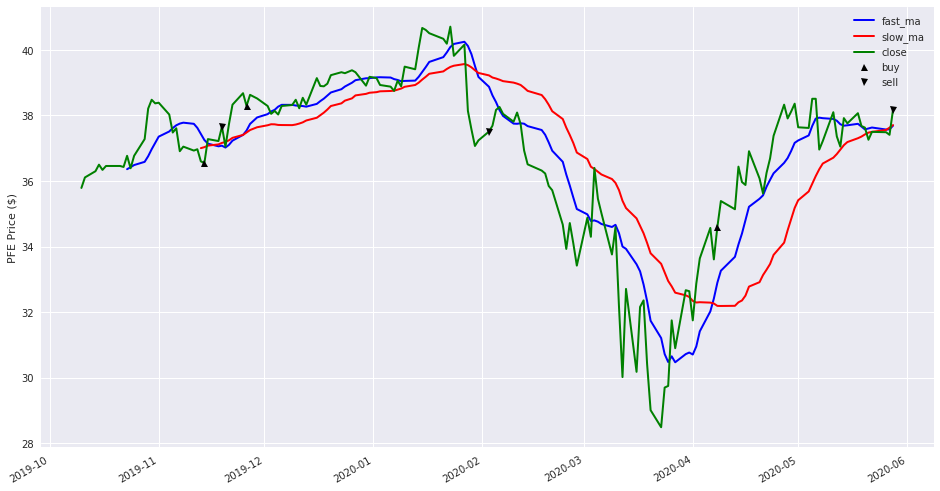

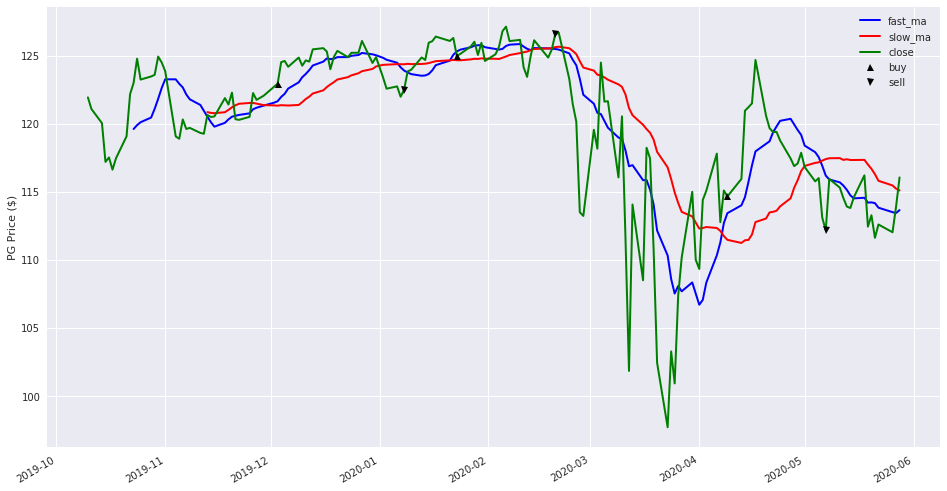

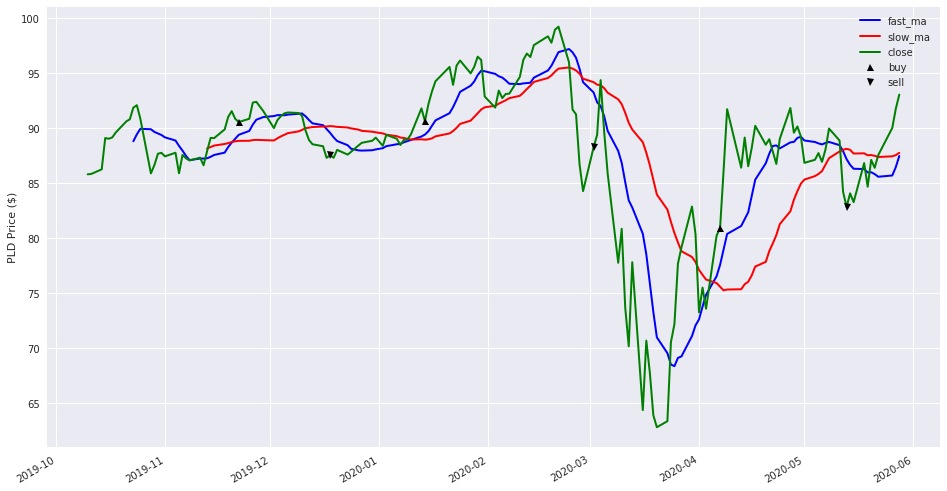

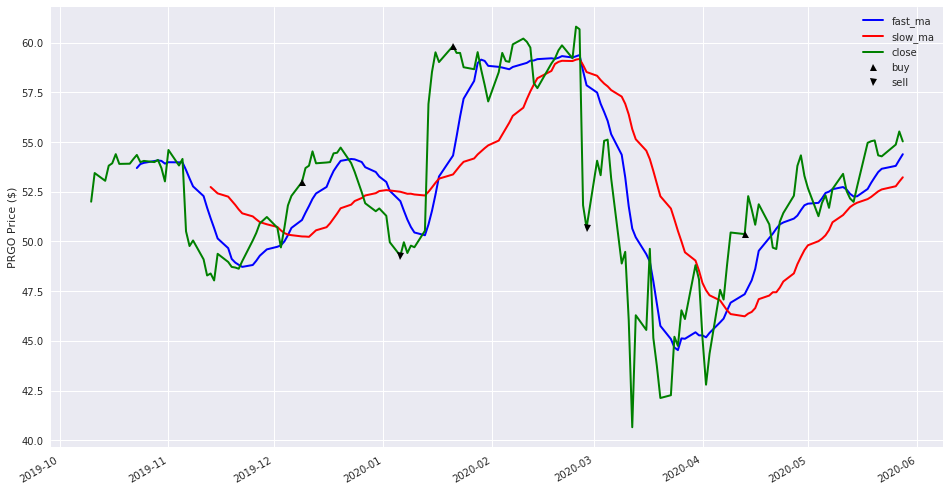

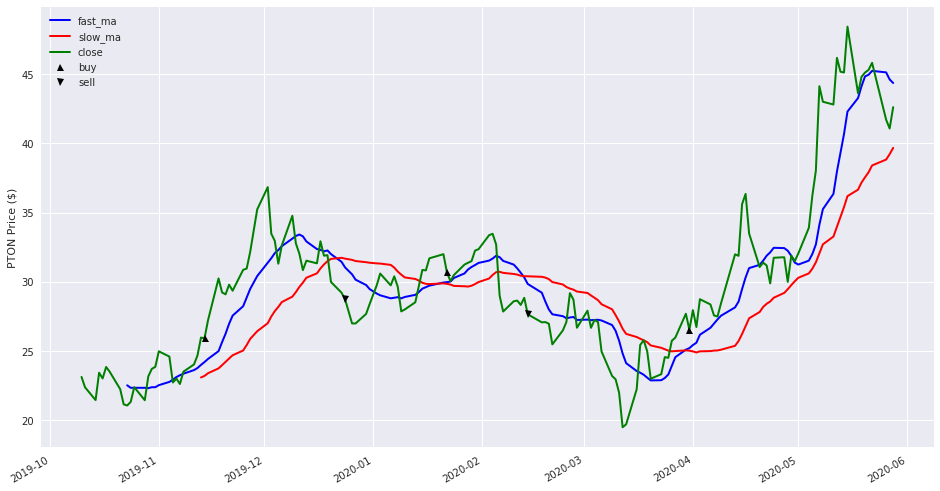

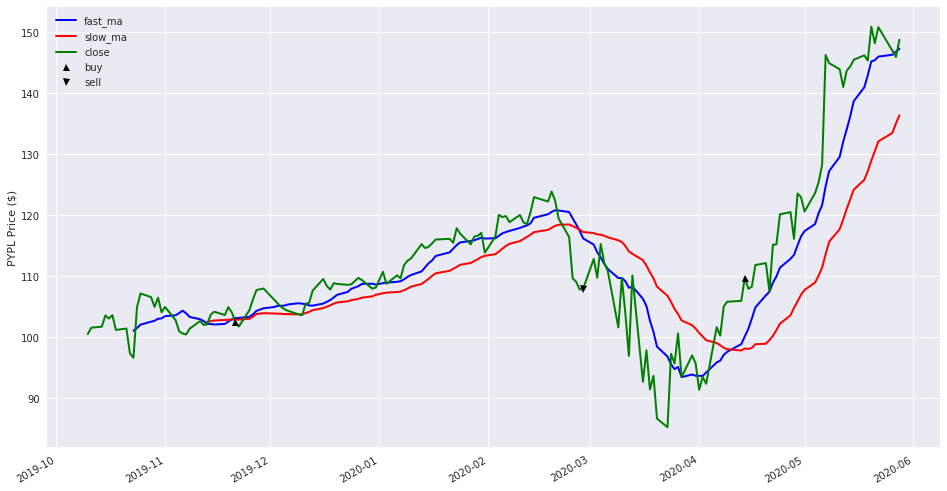

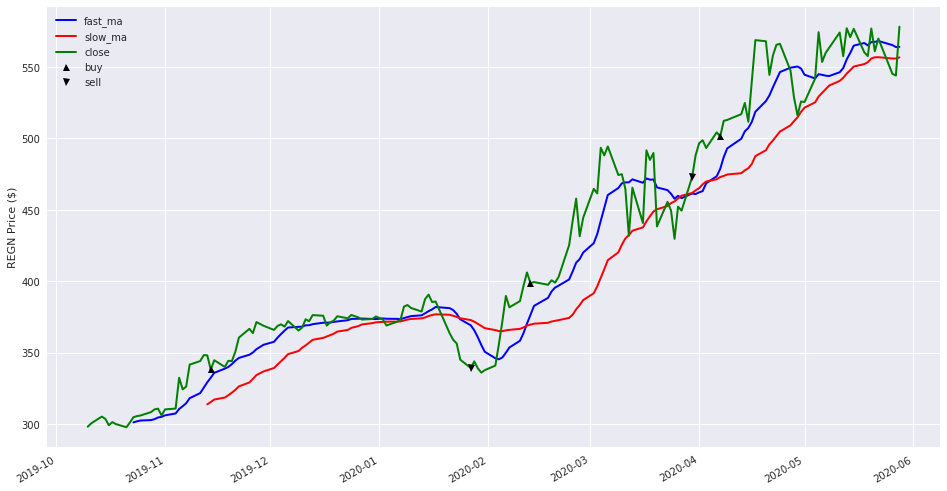

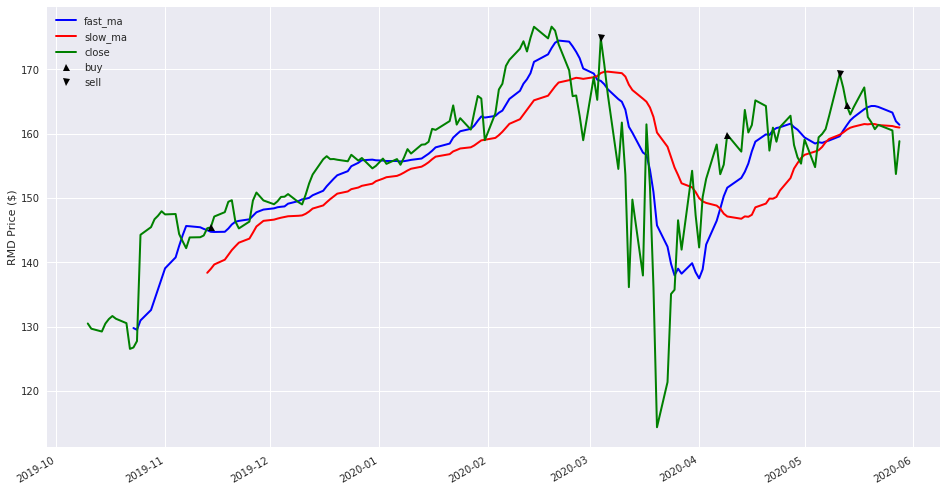

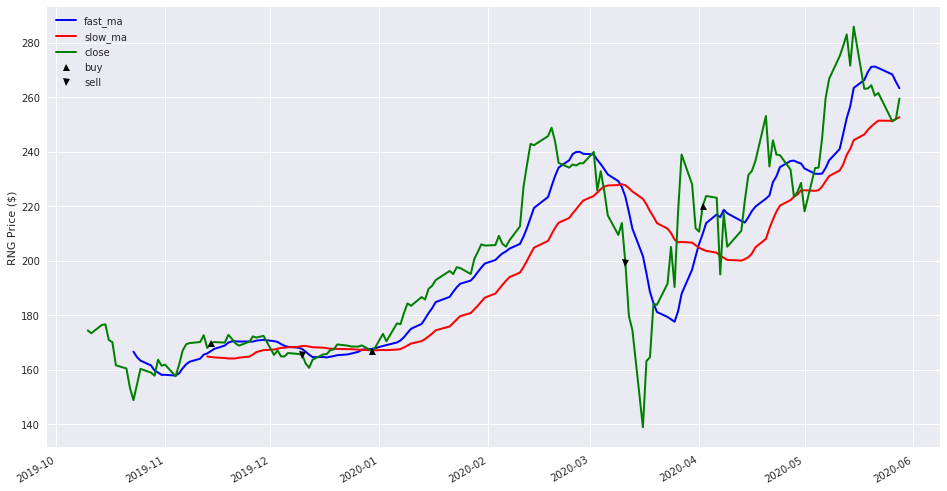

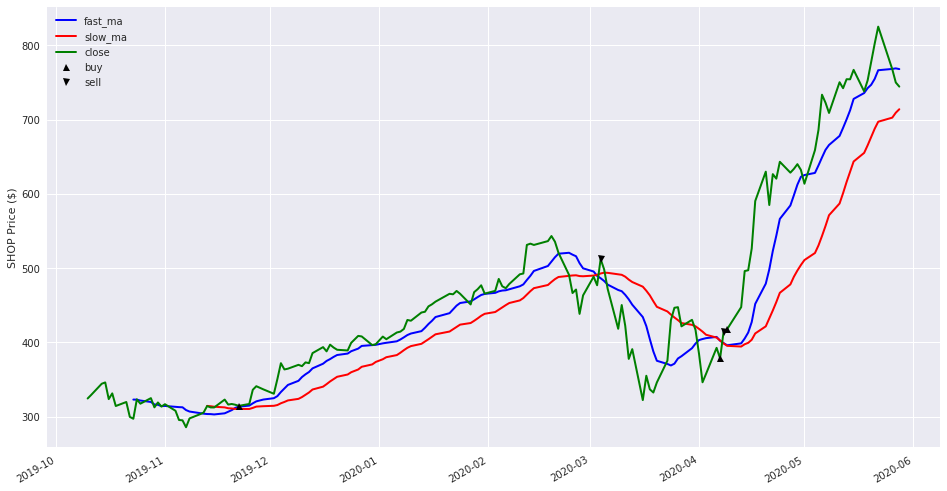

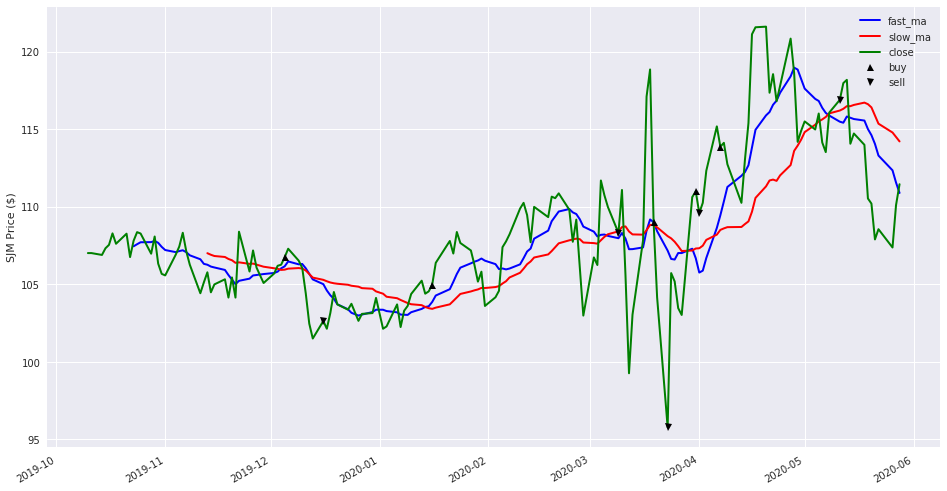

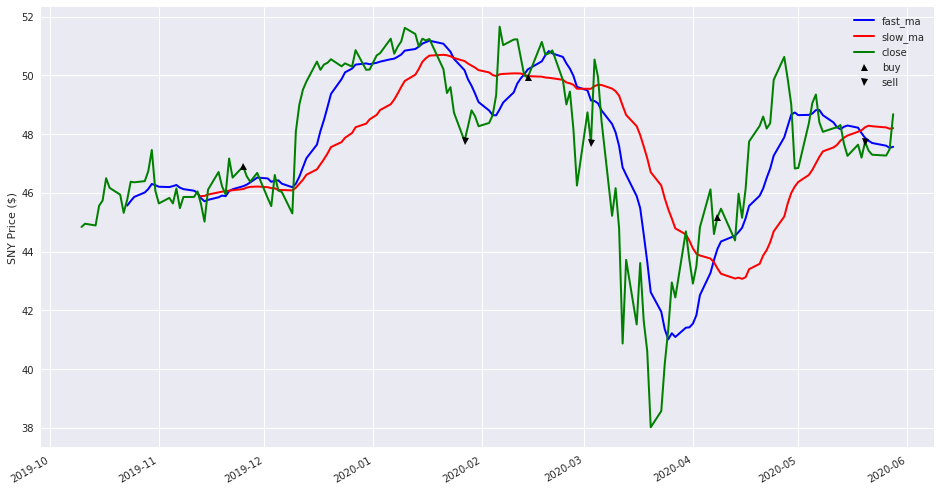

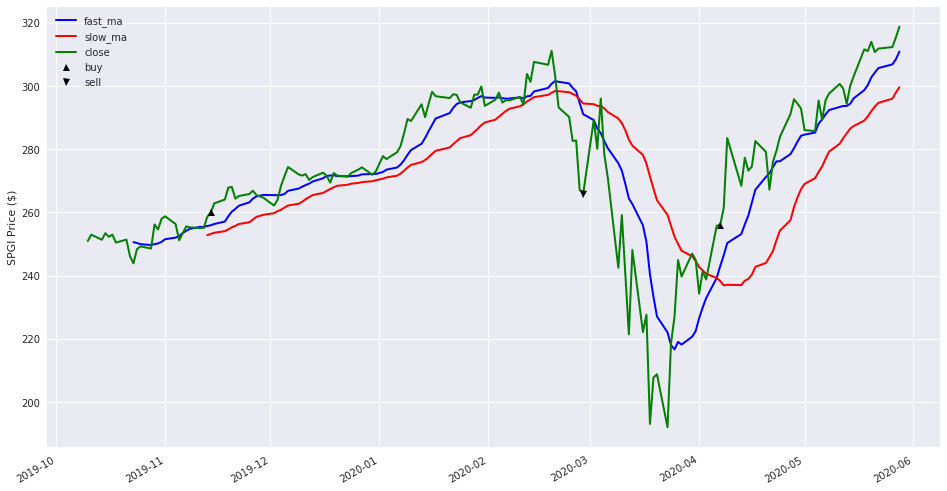

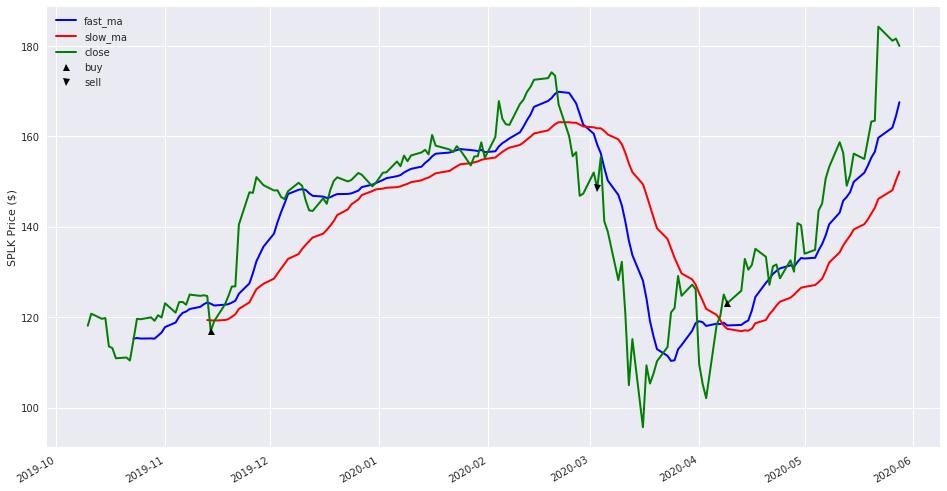

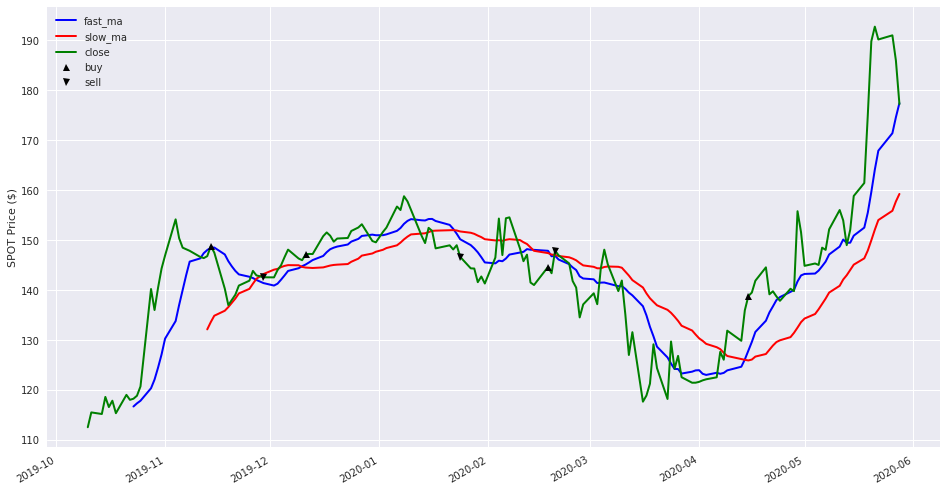

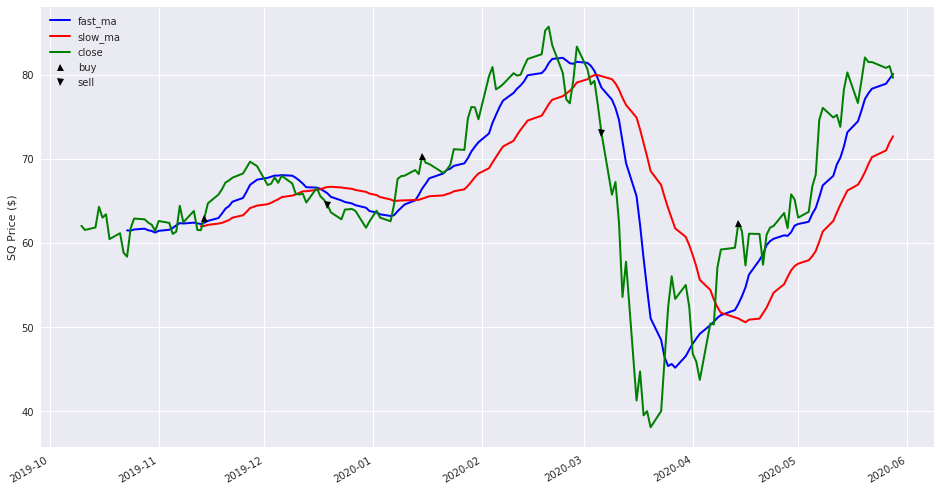

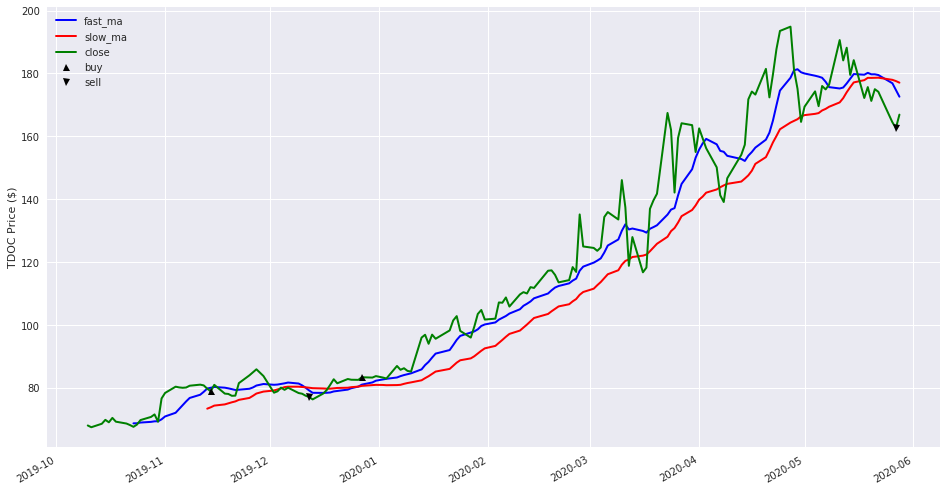

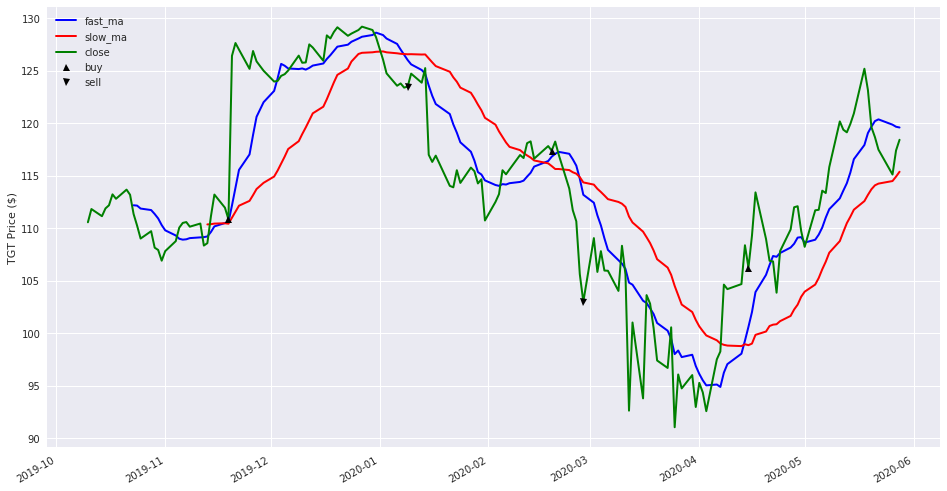

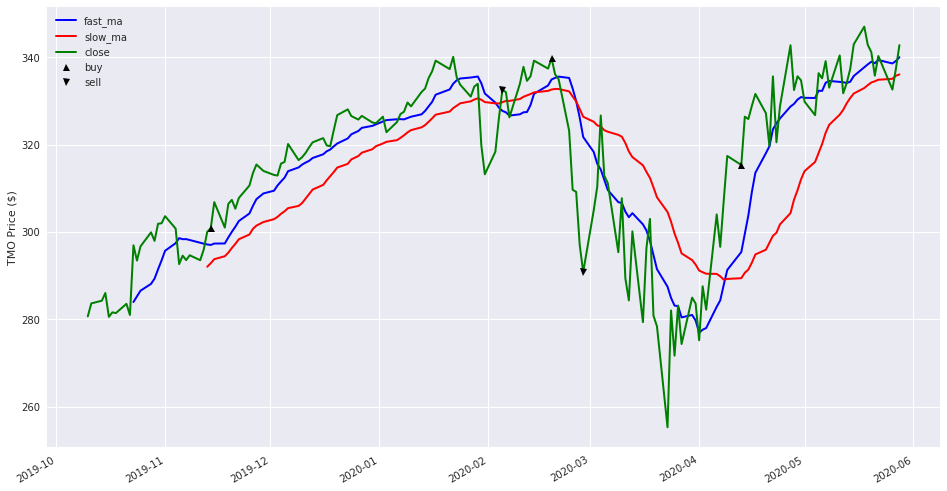

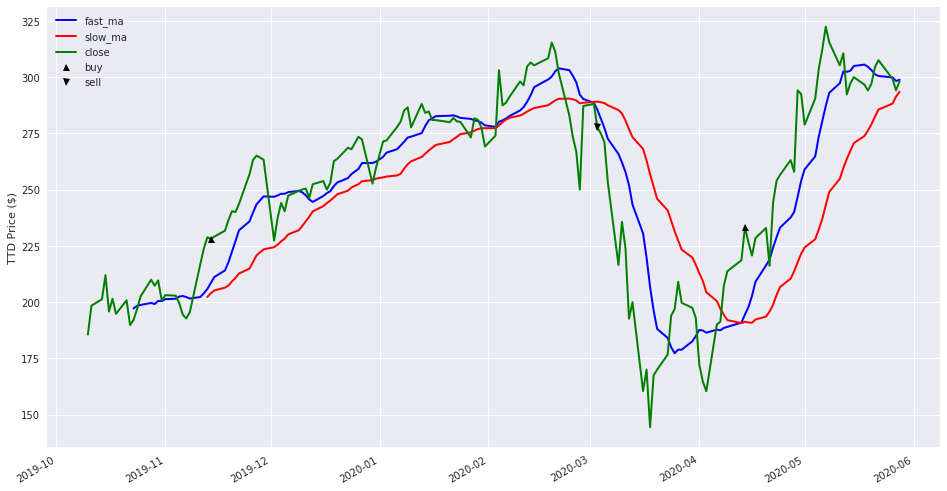

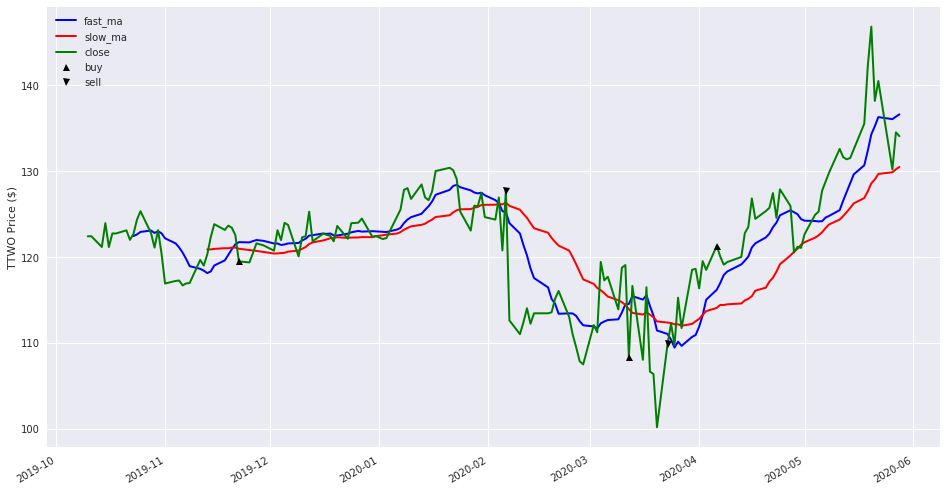

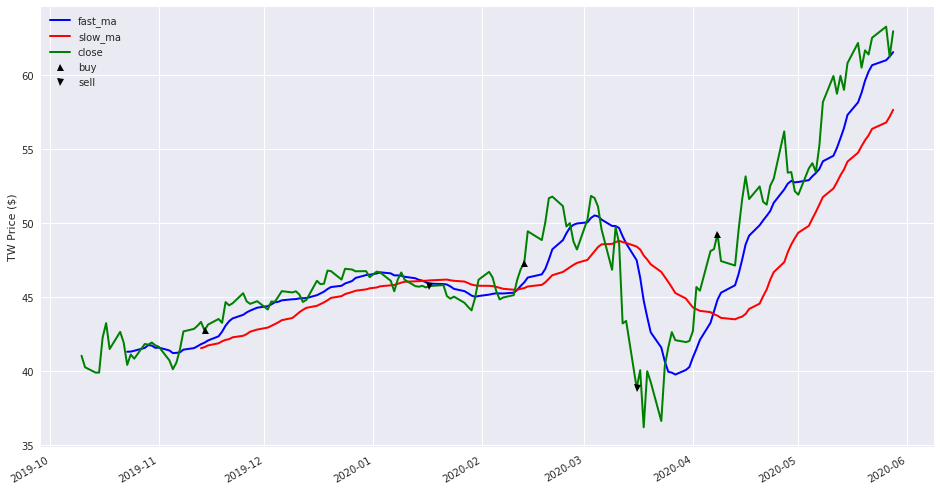

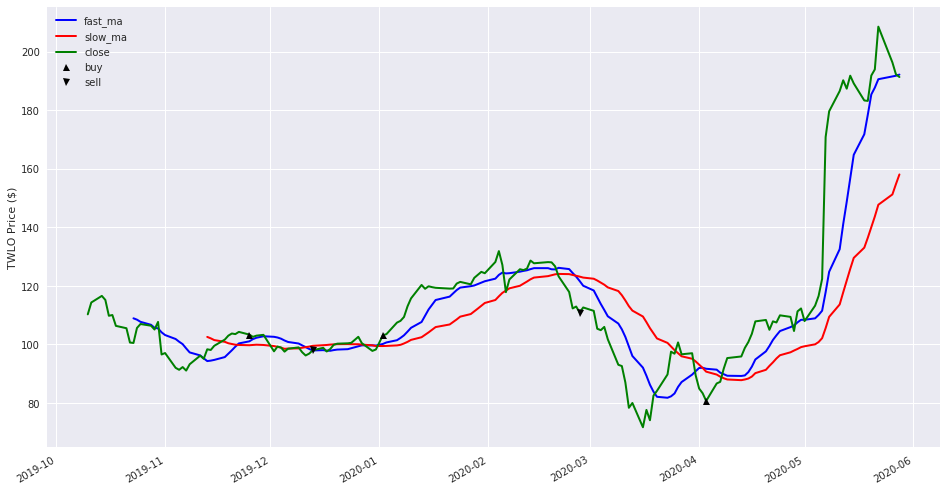

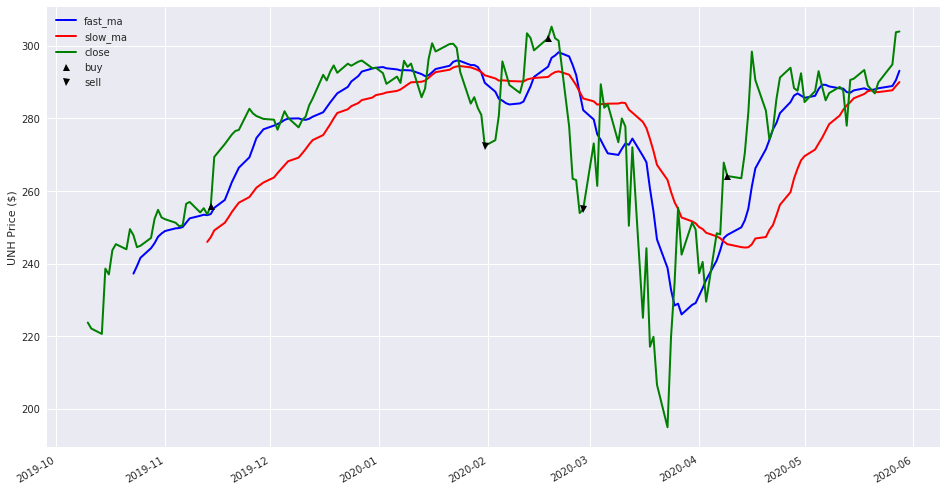

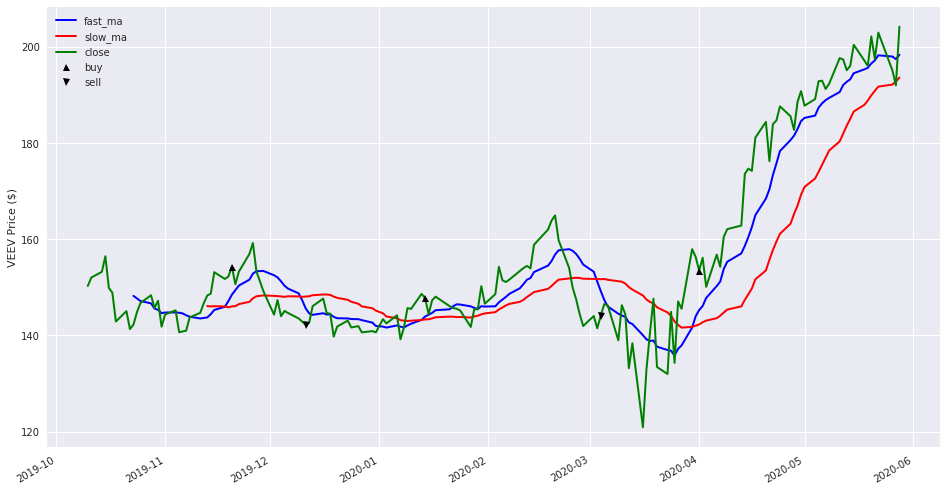

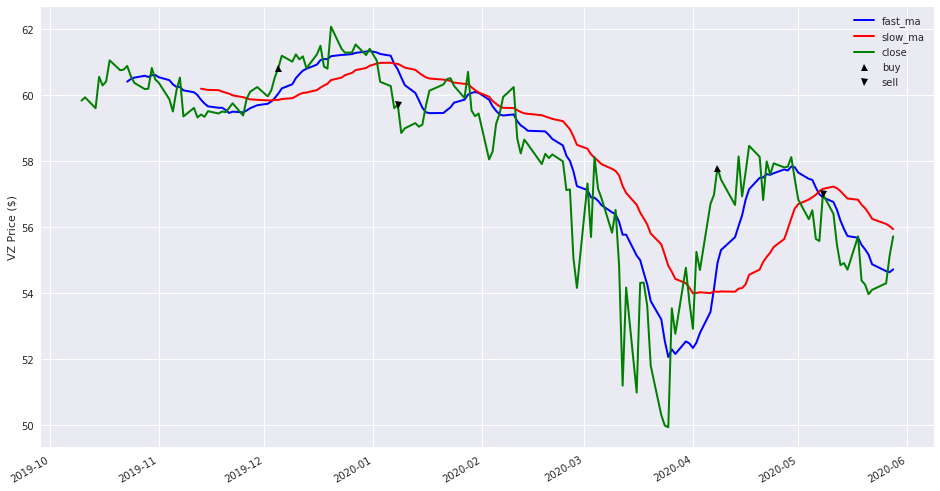

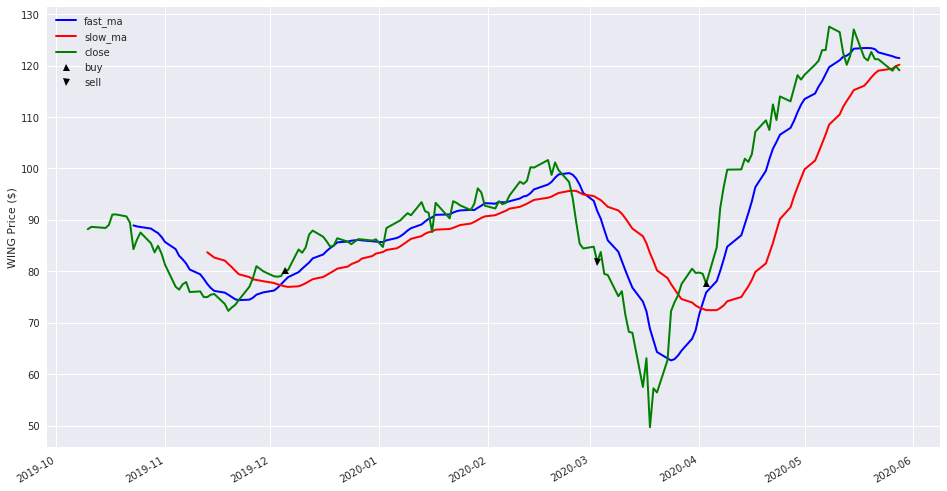

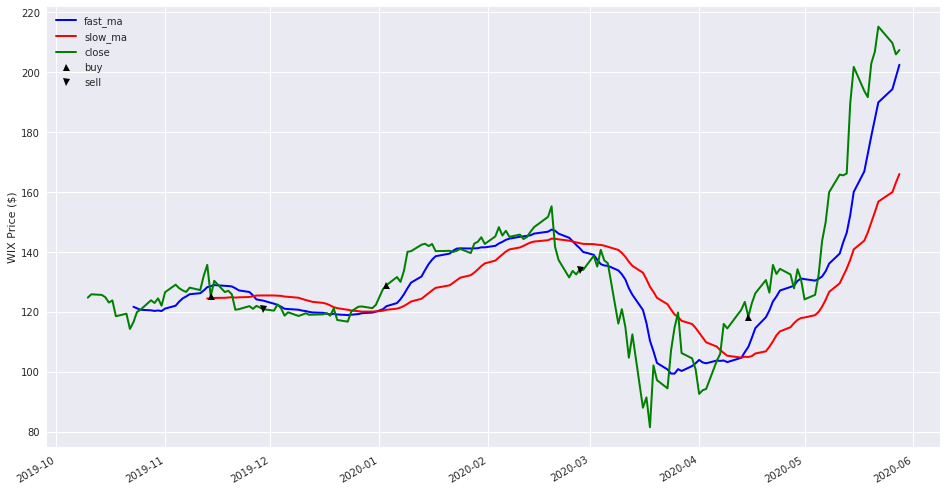

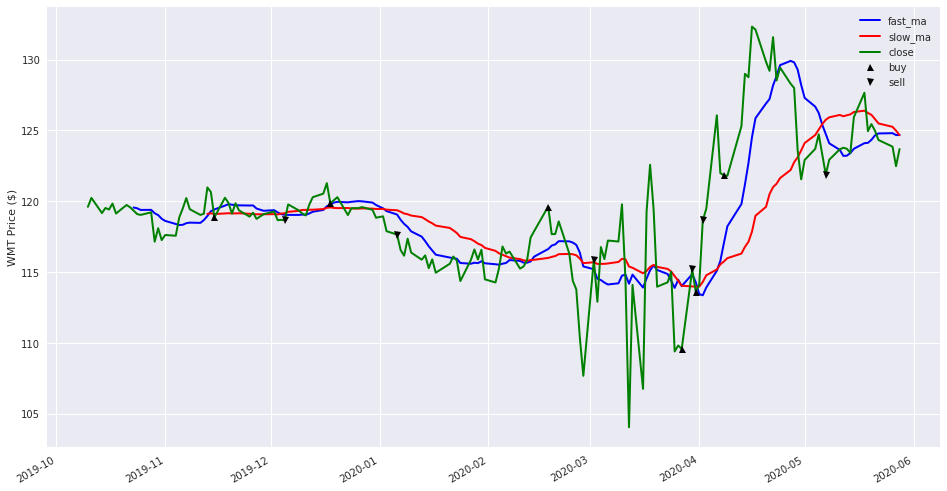

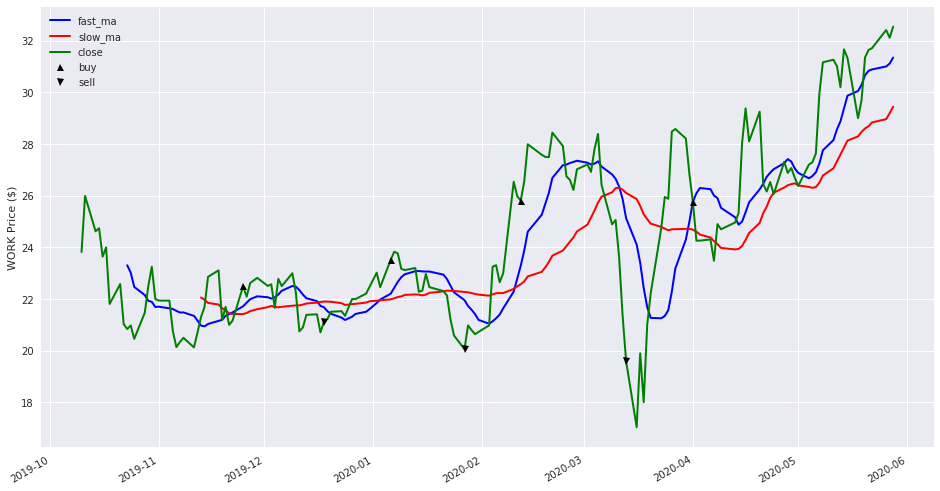

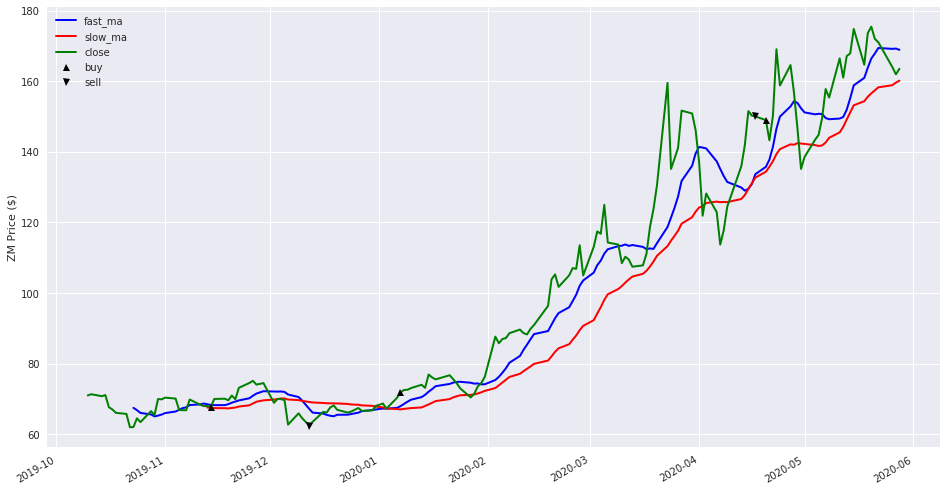

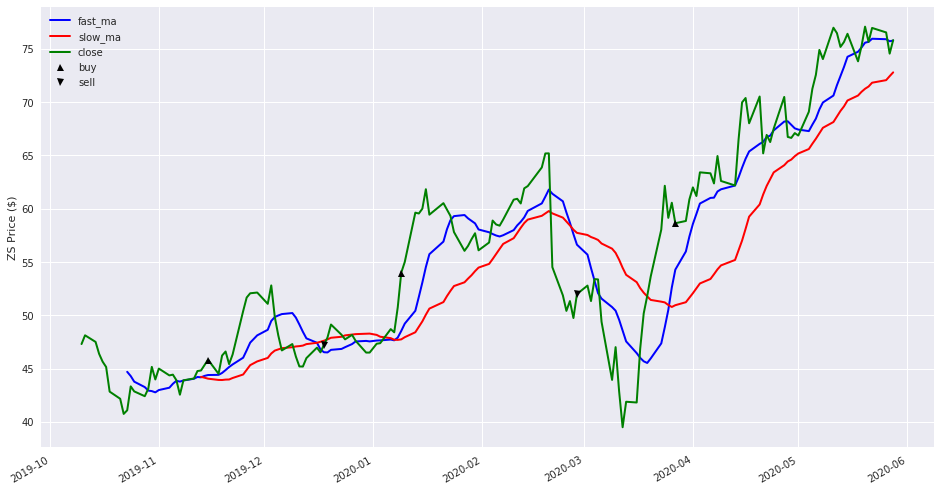

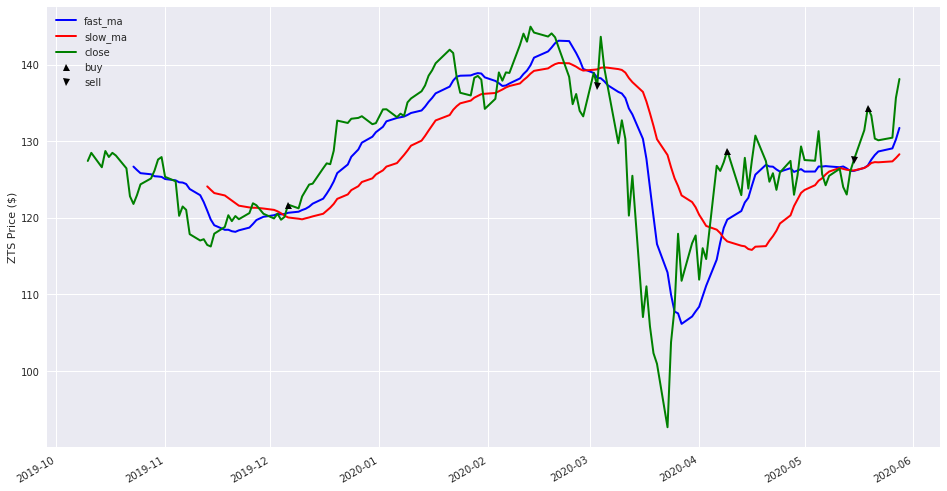

In [40]:
for ticker in stock_list:
    graph_data = model_collection[ticker][:]
    fig = plt.figure(figsize=(16,9))
    ylabel = ticker + ' Price ($)'
    ax1 = fig.add_subplot(111, ylabel=ylabel)
    graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
    graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
    graph_data['close'].plot(ax=ax1, color='g', lw=2.)
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend()
    plt.show()

In [41]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4. Back-test Model

In [42]:
if notifyStatus: email_notify("Task 4. Back-test Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
def trading_portfolio_generation(ticker_symbol, initial_fund, trading_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trading_model[ticker_symbol].index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sale_proceed', 'gain_loss', 'cash_value', 'position_value', 'total_value', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sale_proceed'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_value'] = initial_fund
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_value'] = initial_fund
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_value'] - initial_fund

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trading_model[ticker_symbol].iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trading_model[ticker_symbol].iloc[i]['open'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sale_proceed'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_value'] = portfolio.iloc[i-1]['cash_value'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trading_model[ticker_symbol].iloc[i]['open'] * portfolio.iloc[i]['trade_action']
            if verbose: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model[ticker_symbol].iloc[i]['open'])
        elif (trading_model[ticker_symbol].iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sale_proceed'] = trading_model[ticker_symbol].iloc[i]['open'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model[ticker_symbol].iloc[i]['open'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_value'] = portfolio.iloc[i-1]['cash_value'] + portfolio.iloc[i]['sale_proceed']
            recent_cost = 0.00
            if verbose: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model[ticker_symbol].iloc[i]['open'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sale_proceed'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_value'] = portfolio.iloc[i-1]['cash_value']
        portfolio.iloc[i]['position_value'] = trading_model[ticker_symbol].iloc[i]['close'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_value'] = portfolio.iloc[i]['cash_value'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_value'] - initial_fund

    return portfolio

In [44]:
initial_capital = 0
portfolio_collection = {}

stock_status = stock_meta.copy()
stock_status.drop(['Share_Outstanding'], axis=1, inplace=True)

for ticker in stock_list:
    print('Processing portfolio for ticker symbol:', ticker)
    portfolio_collection[ticker] = trading_portfolio_generation(ticker, initial_capital, model_collection)
    trade_transactions = portfolio_collection[ticker][portfolio_collection[ticker].trade_action != 0]
    print(trade_transactions)
    stock_status.loc[ticker, 'per_share_pandl'] = portfolio_collection[ticker].accumu_return[-1]
    print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, stock_status.loc[ticker, 'per_share_pandl']))
    stock_status.loc[ticker, 'per_share_return'] = portfolio_collection[ticker].accumu_return[-1] / trade_transactions.cost_basis[0]
    print('Accumulated return percentage based on the cost of first share of stock investment: %.2f%%\n' % (stock_status.loc[ticker, 'per_share_return'] * 100))
    if trade_transactions.iloc[-1]['trade_action'] == 1:
        stock_status.loc[ticker, 'current_status'] = 'Holding Position'
        stock_status.loc[ticker, 'last_action_date'] = trade_transactions.index.tolist()[-1]
    else:
        stock_status.loc[ticker, 'current_status'] = 'Waiting to Enter'
        stock_status.loc[ticker, 'last_action_date'] = trade_transactions.index.tolist()[-1]

Processing portfolio for ticker symbol: AAPL
           trade_action qty_onhand cost_basis sale_proceed gain_loss cash_value position_value total_value accumu_return
2019-11-14            1          1     263.75            0         0    -263.75         262.64       -1.11         -1.11
2020-02-26           -1          0          0       286.53     22.78      22.78              0       22.78         22.78
2020-04-14            1          1        280            0         0    -257.22         287.05       29.83         29.83
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $61.03
Accumulated return percentage based on the cost of first share of stock investment: 23.14%

Processing portfolio for ticker symbol: ABBV
           trade_action qty_onhand cost_basis sale_proceed gain_loss cash_value position_value total_value accumu_return
2019-11-14            1          1      86.48            0         0     -86.48          87.63       

In [45]:
stock_status.sort_values(by=['current_status', 'last_action_date'], ascending=False)

Name  per_share_pandl  per_share_return    current_status last_action_date
Symbol                                                                                                     
PFE                            Pfizer            3.630          0.099289  Waiting to Enter       2020-05-28
COR                   CoreSite Realty            4.580          0.039551  Waiting to Enter       2020-05-27
CPB                     Campbell Soup          -11.960         -0.249011  Waiting to Enter       2020-05-27
GOLD                     Barrick Gold            4.270          0.254773  Waiting to Enter       2020-05-27
KR                          Kroger Co            1.000          0.037010  Waiting to Enter       2020-05-27
PEP                           PepsiCo          -11.930         -0.087297  Waiting to Enter       2020-05-27
TDOC                          Teladoc           72.580          0.906570  Waiting to Enter       2020-05-27
BSX     Boston Scientific Corporation            1.980          0.047768  Waiting to Enter       2020-05-22
CTXS                   Citrix Systems           17.310          0.155302  Waiting to Enter       2020-05-21
DHR                           Danaher           31.000          0.216677  Waiting to Enter       2020-05-21
LLY                         Eli Lilly           18.400          0.163905  Waiting to Enter       2020-05-21
GSK                   GlaxoSmithKline            3.440          0.078539  Waiting to Enter       2020-05-20
SNY                            Sanofi            3.080          0.065911  Waiting to Enter       2020-05-20
ABT                       Abbott Labs            4.210          0.050065  Waiting to Enter       2020-05-15
CAG                           Conagra            7.200          0.254777  Waiting to Enter       2020-05-15
GILD                  Gilead Sciences            5.180          0.077684  Waiting to Enter       2020-05-15
JNJ                 Johnson & Johnson           16.340          0.124704  Waiting to Enter       2020-05-14
EQIX                          Equinix           41.480          0.074979  Waiting to Enter       2020-05-13
K                             Kellogg            5.410          0.083824  Waiting to Enter       2020-05-13
PLD                          Prologis          -13.500         -0.148450  Waiting to Enter       2020-05-13
BAX          Baxter International Inc            6.090          0.074241  Waiting to Enter       2020-05-12
CHWY                            Chewy           10.970          0.459188  Waiting to Enter       2020-05-12
CNC                           Centene            5.150          0.092860  Waiting to Enter       2020-05-12
CCI                      Crown Castle           14.800          0.108520  Waiting to Enter       2020-05-11
COST                           Costco            4.148          0.013627  Waiting to Enter       2020-05-11
SJM                        JM Smucker          -20.990         -0.197367  Waiting to Enter       2020-05-11
AKAM              Akamai Technologies            8.440          0.095013  Waiting to Enter       2020-05-08
VZ                            Verizon           -2.000         -0.032987  Waiting to Enter       2020-05-08
AMT                    American Tower            7.660          0.035661  Waiting to Enter       2020-05-07
CL                  Colgate-Pammolive            2.790          0.041029  Waiting to Enter       2020-05-07
PG                   Procter & Gamble           -0.150         -0.001226  Waiting to Enter       2020-05-07
WMT                           Walmart          -16.910         -0.140123  Waiting to Enter       2020-05-07
MDLZ                         Mondelez            1.720          0.033173  Waiting to Enter       2020-05-04
AMD            Advanced Micro Devices           15.076          0.401919  Holding Position       2020-05-22
HRL                            Hormel            6.460          0.153008  Holding Position       2020-05-22
D                     Dominion Energy

In [46]:
if notifyStatus: email_notify("Task 4. Back-test Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5. Evaluate Performance

In [47]:
if notifyStatus: email_notify("Task 5. Evaluate Performance has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
# Not applicable for this iteration of the project

In [49]:
if notifyStatus: email_notify("Task 5. Evaluate Performance completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:14:35.254177
